In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import (
    TimeSeriesSplit, cross_validate, 
    KFold, train_test_split,
    ShuffleSplit
)
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import tree

from sklearn.metrics import mean_absolute_error
from scipy.stats import norm

In [3]:
# this are periods when 1,2,3,4 HEs were under operation
time_periods = [
    ("2022-09-12","2022-09-13"),
    ("2022-10-17","2022-10-21"), ("2022-11-08","2022-11-11"), ("2022-11-15","2022-11-18"),
    ("2022-11-22","2022-11-25"), ("2022-11-29","2022-12-02"), ("2022-12-05","2022-12-09"), 
    ("2022-12-12","2022-12-16"), ("2022-12-19","2022-12-23"), ("2023-01-10","2023-01-13"), 
    ("2023-01-16","2023-01-19"), ("2023-01-24","2023-01-27"), ("2023-01-31","2023-02-03"), 
    ("2023-02-07","2023-02-09"), ("2023-02-13","2023-02-17"), ("2023-02-28","2023-03-03"), 
    ("2023-03-06","2023-03-07"), ("2023-03-09","2023-03-10"), ("2023-03-14","2023-03-17"),
    ("2023-03-27","2023-03-31"), ("2023-04-03","2023-04-07"), ("2023-04-10","2023-04-14"),
#     ("2023-04-17","2023-04-21"), ("2023-05-02","2023-05-05"), ("2023-05-08","2023-05-12"),
#     ("2023-05-15","2023-05-19"), ("2023-05-22","2023-05-26"), ("2023-05-29","2023-06-02"),
#     ("2023-06-05","2023-06-09"),
]

time_periods2 = [
    ("2021-09-06","2021-09-10"), ("2021-09-13","2021-09-17"), ("2021-09-20","2021-10-01"),
    ("2021-10-04","2021-10-08"), ("2021-10-11","2021-10-15"), ("2021-11-08","2021-11-12"),
    ("2021-11-15","2021-11-19"), ("2021-11-22","2021-11-26"), ("2021-11-29","2021-12-03"),
    ("2021-12-07","2021-12-03"), ("2021-12-13","2021-12-17"), ("2021-12-20","2021-12-24"),
    ("2022-01-18","2022-01-21"), ("2022-01-24","2022-01-26"), ("2022-02-01","2022-02-04"),
    ("2022-02-08","2022-02-11"), ("2022-02-14","2022-02-18"), ("2022-02-24","2022-02-25"),
    ("2022-03-01","2022-03-04"), ("2022-03-15","2022-03-18"), ("2022-03-21","2022-03-25"),
    ("2022-03-29","2022-04-01"), ("2022-04-12","2022-04-15"), ("2022-04-18","2022-04-22"),
    ("2022-05-02","2022-05-06"), ("2022-05-09","2022-05-13"), ("2022-05-16","2022-05-20"),
    ("2022-05-23","2022-05-27"), ("2022-06-07","2022-06-10"), ("2022-06-20","2022-06-24"),
    ("2022-06-28","2022-07-01"),
    
]

time_periods3 = [
    ("2020-10-12","2020-10-16"), ("2020-10-21","2020-10-23"), ("2020-10-28","2020-10-30"),
    ("2020-11-11","2020-11-13"), ("2020-11-16","2020-11-20"), ("2020-11-24","2020-11-27"),
    ("2020-12-03","2020-12-04"), ("2020-12-07","2020-12-11"), ("2020-12-16","2020-12-18"), 
    ("2020-12-24","2020-12-25"), ("2020-12-29","2020-12-30"), ("2021-01-12","2021-01-15"),
    ("2021-01-18","2021-01-22"), ("2021-02-01","2021-02-05"), ("2021-02-08","2021-02-12"),
    ("2021-02-15","2021-02-19"), ("2021-03-01","2021-03-05"), ("2021-03-09","2021-03-12"),
    ("2021-03-15","2021-03-19"), ("2021-03-22","2021-03-26"), ("2021-04-01","2021-04-02"),
    ("2021-04-05","2021-04-09"), ("2021-04-05","2021-04-09"), ("2021-04-12","2021-04-16"),
    ("2021-04-20","2021-04-24"), ("2021-04-26","2021-04-30"), ("2021-05-03","2021-05-07"),
    ("2021-05-11","2021-05-15"), ("2021-05-17","2021-05-21"), ("2021-05-24","2021-05-28"),
    ("2021-06-15","2021-06-18"), ("2021-06-21","2021-06-25"), ("2021-06-28","2021-07-02"),
]

In [4]:
# fc 119,120,121
fcs = [
    ("2021-03-09", "2021-04-12"), ("2021-04-12", "2021-05-11"), ("2021-05-11", "2021-09-20")
]

In [5]:
time_periods_all = [*time_periods3, *time_periods2, *time_periods]

### All IDs used
* 299 Т1к после ТО
* 309 Р2контура
* 315 T1k before HE
* 317 Т2к перед ТО
* 319 Т2к после ТО
* 321 T reactor
* 325 Т2к выхТО1
* 327 Твозвуха
* 381 Iвг1
* 395 Iвг2
* 396 Iвг3
* 460 Т2к выхТО2
* 461 Т2к выхТО3
* 462 Т2к выхТО4
* 463 Т2к выхТО5
* 480 Q1k
* 481 Q2контура
#### Second loop I pumps id
* 406 2-1
* 407 2-2
* 408 2-3
* 409 2-4

In [6]:
sys.path.insert(0, os.path.split(os.path.abspath(""))[0])
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))

In [7]:
from preprocessing import CsvRefactorer
from analytics import WaterFlowRates
from statistics import Statistics as st
from data_engineering import PeriodicDataPreprocess, FeatureEngineering
from statistics import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima import model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, ccf

In [9]:
# df = pd.read_excel("rdy_for_fe_121020_to_210423.xlsx", index_col="Timestamp")
# df_nosma = pd.read_excel("rdy_for_fe_121020_to_210423_no_sma.xlsx", index_col="Timestamp")



In [10]:
df_stats = pd.read_excel("rdy_for_stats_121020_090623.xlsx", index_col="Timestamp")

In [11]:
df_stats

P2          Q2      T1aHE      T1bHE      T2aHE  \
Timestamp                                                                
2020-10-13 00:15:00  0.40  648.965000  38.930486  44.731365  30.577720   
2020-10-13 00:20:00  0.40  649.100000  38.781042  44.578379  30.421470   
2020-10-13 12:30:00  0.40  649.405000  38.609375  44.393971  30.268346   
2020-10-13 12:35:00  0.40  649.565000  38.768125  44.535735  30.466581   
2020-10-13 12:40:00  0.40  649.790000  38.930000  44.685735  30.656581   
...                   ...         ...        ...        ...        ...   
2023-06-09 18:50:00  0.47  796.705000  36.469649  39.298125  28.202410   
2023-06-09 18:55:00  0.47  796.235000  34.704649  36.928125  27.512410   
2023-06-09 19:00:00  0.47  795.675000  32.859816  34.468500  26.769763   
2023-06-09 19:10:00  0.47  795.625000  29.621500  30.612000  25.382298   
2023-06-09 19:15:00  0.47  795.888182  28.416738  29.221786  24.790798   

                       T2aHE1    T2aHE2    T2aHE3    T2aHE4    T2aHE5  ...  \
Timestamp                                                              ...   
2020-10-13 00:15:00  0.327025  0.310844  0.334350  0.254655  0.265293  ...   
2020-10-13 00:20:00  0.327382  0.311096  0.335531  0.254442  0.265032  ...   
2020-10-13 12:30:00  0.327532  0.311237  0.336623  0.254181  0.264731  ...   
2020-10-13 12:35:00  0.327680  0.311393  0.337058  0.254373  0.264851  ...   
2020-10-13 12:40:00  0.327796  0.311486  0.337407  0.254468  0.264904  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-09 18:50:00  0.224869  0.254756  0.349321  0.255533  0.198798  ...   
2023-06-09 18:55:00  0.226284  0.262288  0.361283  0.262195  0.201275  ...   
2023-06-09 19:00:00  0.228201  0.273103  0.378453  0.271765  0.204788  ...   
2023-06-09 19:10:00  0.231143  0.292778  0.409223  0.290156  0.211277  ...   
2023-06-09 19:15:00  0.232736  0.303438  0.425751  0.300586  0.215526  ...   

                         HE2_TOP      HE3_TOP      HE4_TOP     HE5_TOP  \
Timestamp                                                                
2020-10-13 00:15:00  2915.616105     0.237047     0.608966    0.352448   
2020-10-13 00:20:00  2916.232210     0.474094     1.217932    0.704896   
2020-10-13 12:30:00  2916.848314     0.711141     1.826898    1.057345   
2020-10-13 12:35:00  2917.464419     0.948189     2.435864    1.409793   
2020-10-13 12:40:00  2918.080524     1.185236     3.044829    1.762241   
...                          ...          ...          ...         ...   
2023-06-09 18:50:00  6575.351434  9724.568991  5476.530847  911.460594   
2023-06-09 18:55:00  6575.513576  9724.676743  5476.648136  911.595446   
2023-06-09 19:00:00  6575.675717  9724.784495  5476.765424  911.730297   
2023-06-09 19:10:00  6575.837859  9724.892248  5476.882712  911.865149   
2023-06-09 19:15:00  6576.000000  9725.000000  5477.000000  912.000000   

                     HE1_status  HE2_status  HE3_status  HE4_status  \
Timestamp                                                             
2020-10-13 00:15:00           1           1           1           1   
2020-10-13 00:20:00           1           1           1           1   
2020-10-13 12:30:00           1           1           1           1   
2020-10-13 12:35:00           1           1           1           1   
2020-10-13 12:40:00           1           1           1           1   
...                         ...         ...         ...         ...   
2023-06-09 18:50:00           1           1           1           1   
2023-06-09 18:55:00           1           1           1           1   
2023-06-09 19:00:00           1           1           1           1   
2023-06-09 19:10:00           1           1           1           1   
2023-06-09 19:15:00           1           1           1           1   

                     HE5_status  HE_TOP_mean  
Timestamp                                     
2020-10-13 00:15:00           1  1166.486134  
2020-10-13 00:20:

In [12]:
df_stats["HE4_TOP"]

Timestamp
2020-10-13 00:15:00       0.608966
2020-10-13 00:20:00       1.217932
2020-10-13 12:30:00       1.826898
2020-10-13 12:35:00       2.435864
2020-10-13 12:40:00       3.044829
                          ...     
2023-06-09 18:50:00    5476.530847
2023-06-09 18:55:00    5476.648136
2023-06-09 19:00:00    5476.765424
2023-06-09 19:10:00    5476.882712
2023-06-09 19:15:00    5477.000000
Name: HE4_TOP, Length: 80292, dtype: float64

<AxesSubplot: xlabel='QbyIP', ylabel='Count'>

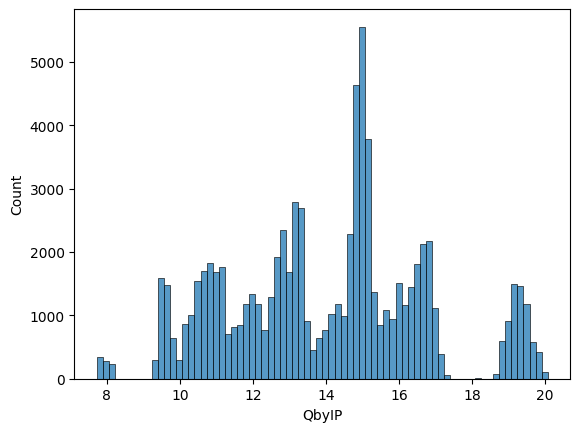

In [13]:
sns.histplot(df_stats["QbyIP"])

<AxesSubplot: xlabel='Q2', ylabel='Count'>

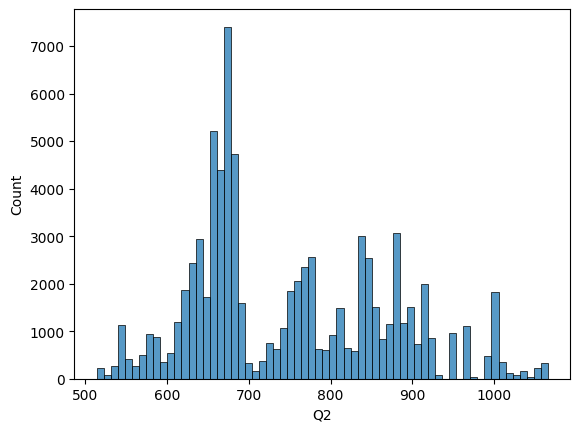

In [14]:
sns.histplot(df_stats["Q2"])

In [275]:
from statsmodels.api import qqplot

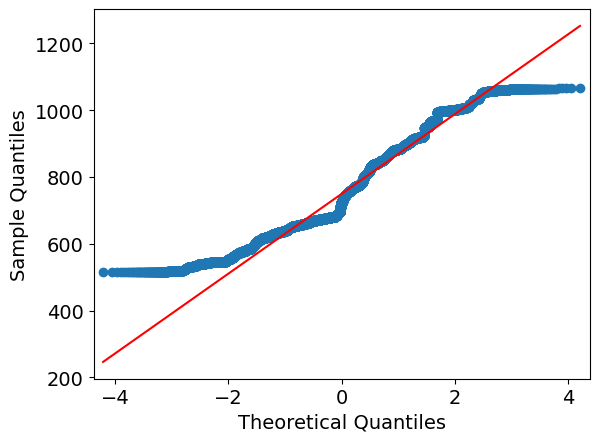

In [281]:
qqplot(df_stats["Q2"].to_numpy(), line ='s')
plt.show()

In [15]:
df_stats_gr = df_stats.groupby(pd.Grouper(freq="2h")).mean()

Timestamp
2020-10-13 00:00:00    14.846935
2020-10-13 12:00:00    14.886677
2020-10-13 14:00:00    14.946375
2020-10-13 16:00:00    14.935981
2020-10-13 18:00:00    14.937355
                         ...    
2023-06-09 10:00:00    12.434544
2023-06-09 12:00:00    12.413073
2023-06-09 14:00:00    12.360581
2023-06-09 16:00:00    12.130565
2023-06-09 18:00:00    12.101699
Name: QbyIP, Length: 1124, dtype: float64


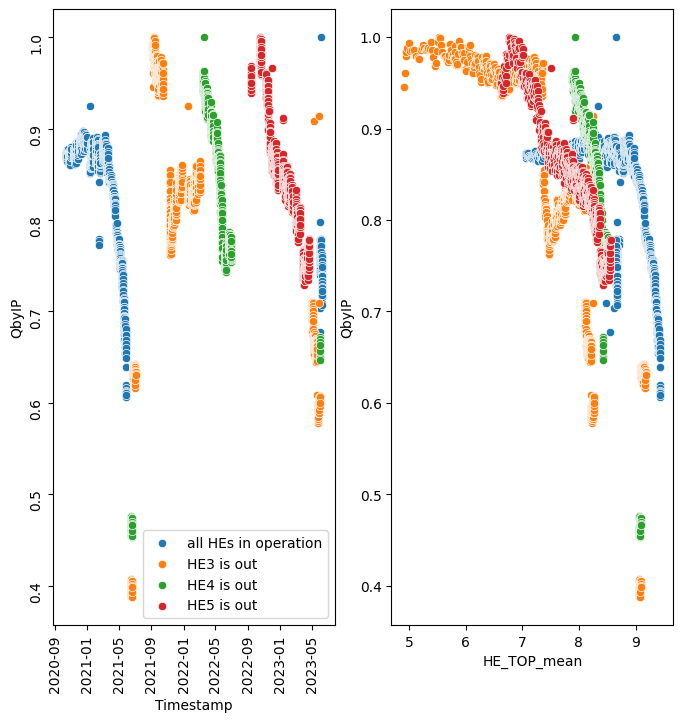

In [16]:

fig, axs = plt.subplots(1,2, figsize=(8,8))

qbyip = df_stats_gr["QbyIP"]

qbyip_all = qbyip[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
].dropna(axis=0)
qbyip3 = qbyip[df_stats_gr["HE3_status"] == 0].dropna(axis=0)
qbyip4 = qbyip[df_stats_gr["HE4_status"] == 0].dropna(axis=0)
qbyip5 = qbyip[df_stats_gr["HE5_status"] == 0].dropna(axis=0)

print(qbyip_all)

hetop_all = df_stats_gr[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
]["HE_TOP_mean"].dropna(axis=0)
hetop3 = df_stats_gr[df_stats_gr["HE3_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop4 = df_stats_gr[df_stats_gr["HE4_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop5 = df_stats_gr[df_stats_gr["HE5_status"] == 0]["HE_TOP_mean"].dropna(axis=0)


sns.scatterplot(qbyip_all / qbyip_all.max(), ax=axs[0], label="all HEs in operation")
sns.scatterplot(qbyip3 / qbyip3.max(), ax=axs[0], label="HE3 is out")
sns.scatterplot(qbyip4 / qbyip4.max(), ax=axs[0], label="HE4 is out")
sns.scatterplot(qbyip5 / qbyip5.max(), ax=axs[0], label="HE5 is out")
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].max(), ax=axs[0])

sns.scatterplot(x=np.log(hetop_all), y=qbyip_all / qbyip_all.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop3), y=qbyip3 / qbyip3.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop4), y=qbyip4 / qbyip4.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop5), y=qbyip5 / qbyip5.max(), ax=axs[1])

axs[0].tick_params(rotation=90)
# sns.scatterplot(qbyip / df_stats.loc[:, ["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1))

# On a first look, all curves have similar trends and no matter what HEs are in operation
# However, the cycles that starts from 0 (HE_TOP_mean) have 2 different trends
# It's quite obvious that each cycle is non-stationry around QbyIP

# I assume that data of winter of 2021 is not clear cuz Tair is hardly reach -5
# However usually it dropsbelow -20 -> absolutly anomaly data
## Data till april of 2021 has dropped

In [17]:
# df_stats = df_stats.loc["2021-04":, :]
df_stats.shape

(80292, 35)

In [18]:
df_stats["HEs_num"] = df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)
df_stats["Q2_HEs_num"] = df_stats["Q2"] / df_stats["HEs_num"]
df_stats["QbyIP_HEs_num"] = df_stats["QbyIP"] / df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)


In [19]:
df_stats.columns

Index(['P2', 'Q2', 'T1aHE', 'T1bHE', 'T2aHE', 'T2aHE1', 'T2aHE2', 'T2aHE3',
       'T2aHE4', 'T2aHE5', 'T2bHE', 'Tair', 'Treactor', 'p21', 'p22', 'p23',
       'p24', 'dt1', 'dt2', 'pumps2', 'dt_circuits_coef',
       'dt_circuits_coef_delta', 'I2mean', 'QbyIP', 'HE1_TOP', 'HE2_TOP',
       'HE3_TOP', 'HE4_TOP', 'HE5_TOP', 'HE1_status', 'HE2_status',
       'HE3_status', 'HE4_status', 'HE5_status', 'HE_TOP_mean', 'HEs_num',
       'Q2_HEs_num', 'QbyIP_HEs_num'],
      dtype='object')

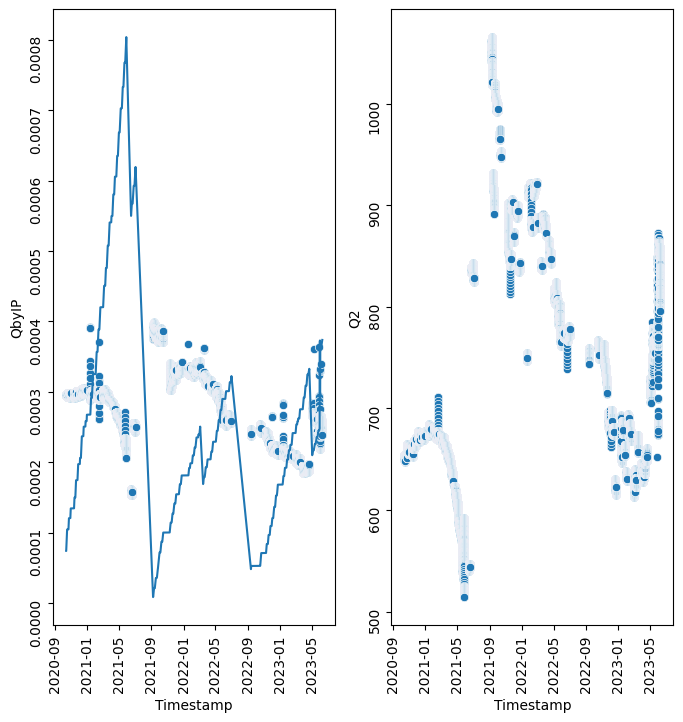

In [20]:
fig, axs = plt.subplots(1,2, figsize=(8,8))
sns.scatterplot(df_stats["QbyIP"]/df_stats_gr["QbyIP"].sum(), ax=axs[0])
sns.lineplot(df_stats["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.scatterplot(df_stats["Q2"], ax=axs[1])

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

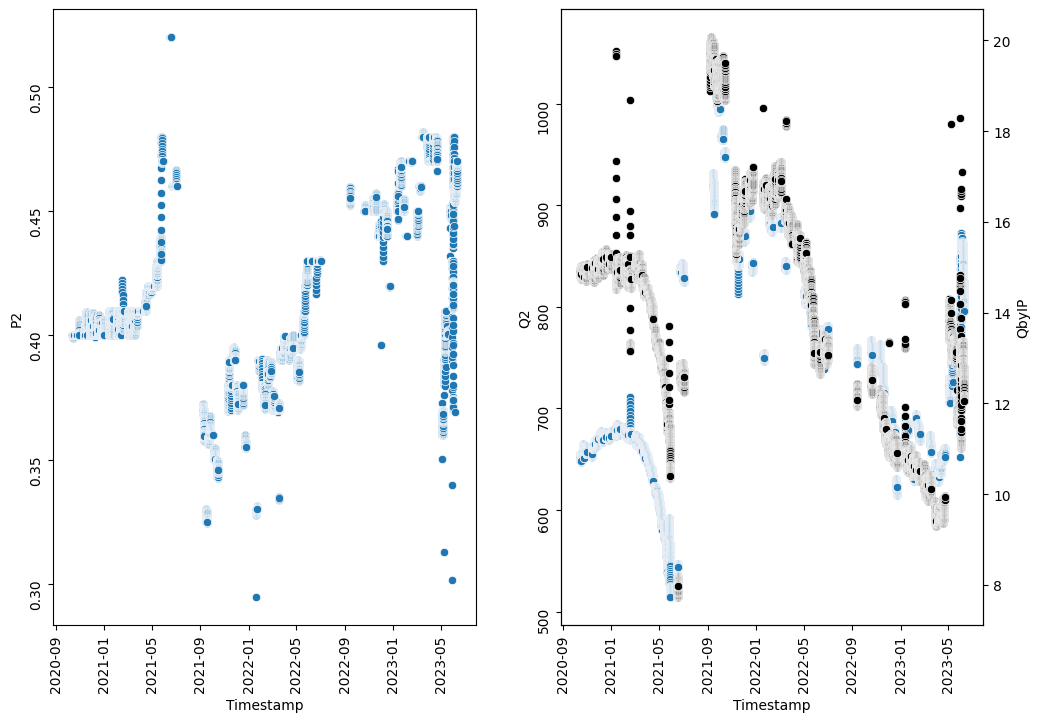

In [21]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
sns.scatterplot(df_stats["P2"], ax=axs[0])
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.scatterplot(df_stats["Q2"], ax=axs[1])
axs11 = axs[1].twinx()
sns.scatterplot(df_stats["QbyIP"], color="black", ax=axs11)
axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

# From diary of maintenance of reactor systems i've learned that nozzles where cleaned only at summer of 2020, 2021. So they status must be taken into account

In [22]:
fe = FeatureEngineering(df_stats)

In [23]:
nozzles_periods = [
    ("2020-10-12", "2021-07-02"), 
    ("2021-09-06", "2023-06-09")
]
df_stats = fe.make_time_onpower_feature(
    time_periods=nozzles_periods,
    feature_name="Nozzles_TOP"
)

[2.38287591e-01 4.76575182e-01 7.14862773e-01 ... 6.31152342e+03
 6.31176171e+03 6.31200000e+03] 26489 26489
[2.85932011e-01 5.71864022e-01 8.57796034e-01 ... 1.53834281e+04
 1.53837141e+04 1.53840000e+04] 53803 53803


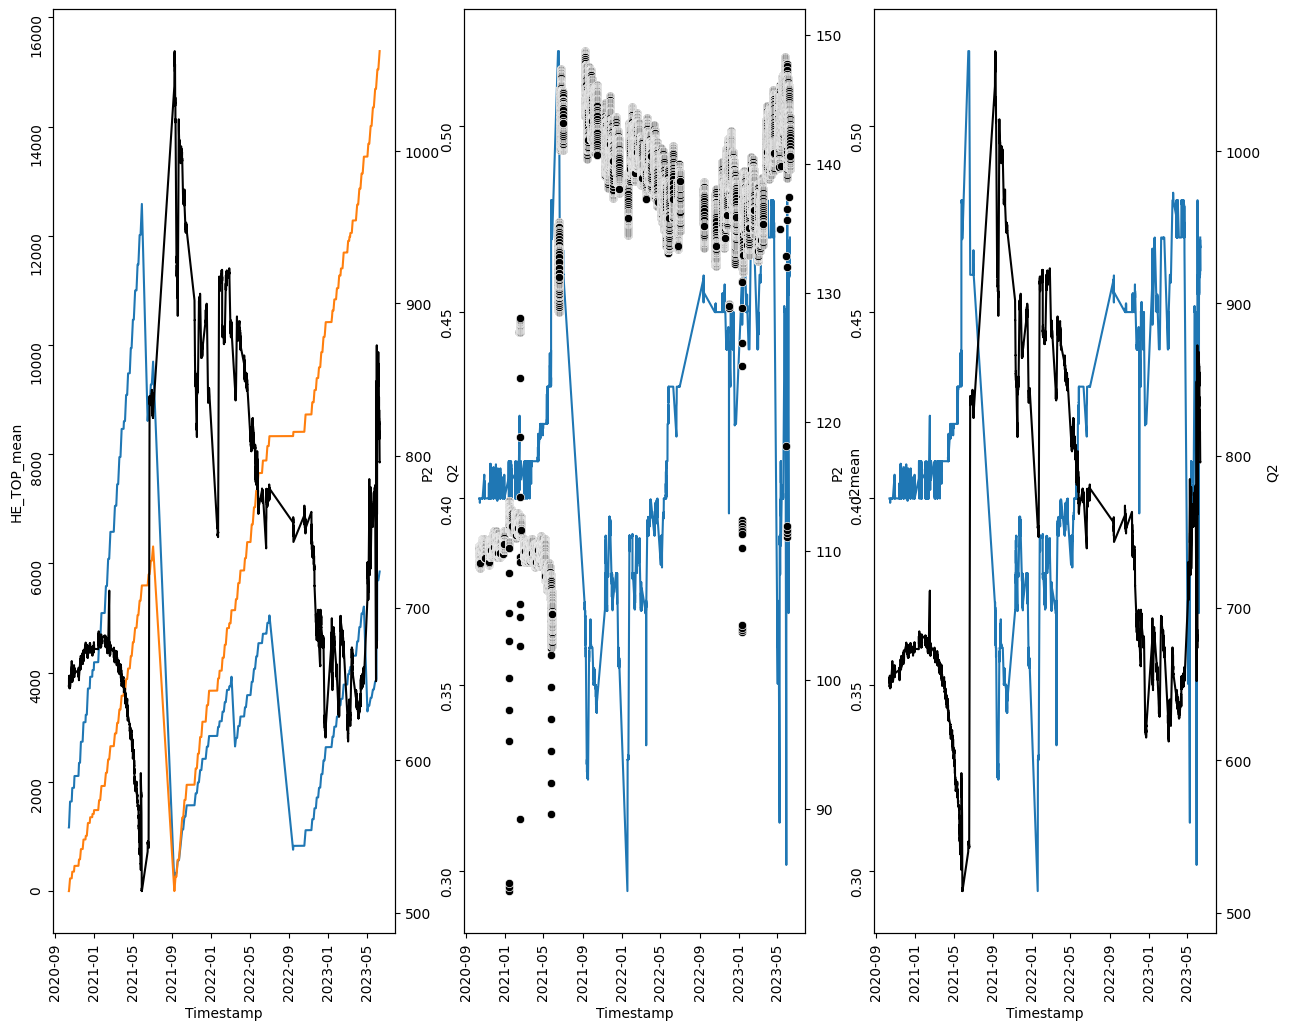

In [24]:
fig, axs = plt.subplots(1,3, figsize=(15,12))
ax0 = axs[0].twinx()
sns.lineplot(df_stats["Q2"], color="black", ax=ax0)
sns.lineplot(df_stats["HE_TOP_mean"], ax=axs[0])
sns.lineplot(df_stats["Nozzles_TOP"], ax=axs[0])

ax1 = axs[1].twinx()
sns.lineplot(df_stats["P2"], ax=axs[1])
sns.scatterplot(df_stats["I2mean"], color="black", ax=ax1)

ax2 = axs[2].twinx()
sns.lineplot(df_stats["P2"], ax=axs[2])
sns.lineplot(df_stats["Q2"], color="black", ax=ax2)

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)
axs[2].tick_params(rotation=90)

In [25]:
df_stats["pumps2"].value_counts()

234     57963
123      9155
134      7816
124      4377
1234      981
Name: pumps2, dtype: int64

<AxesSubplot: ylabel='QbyIP'>

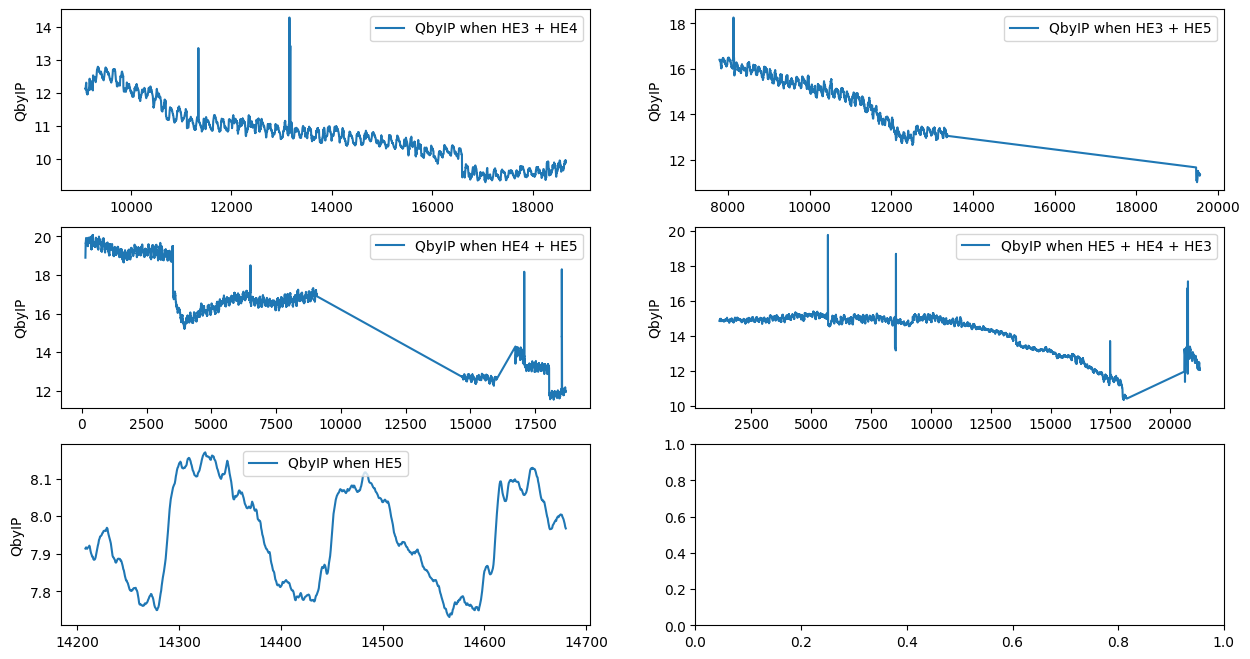

In [26]:
fig, axs = plt.subplots(3,2, figsize=(15,8))
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
#     y=df_stats["QbyIP"],
#     ax=axs[0][0],
#     label="Bare QbyIP"
# )
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5"
)


# As we can see from dependencies above:
## Strong dependencies from what HE operated 
# Need to consider  dependencies to operated pumps  additionally to aquired data

<AxesSubplot: xlabel='Nozzles_TOP', ylabel='QbyIP'>

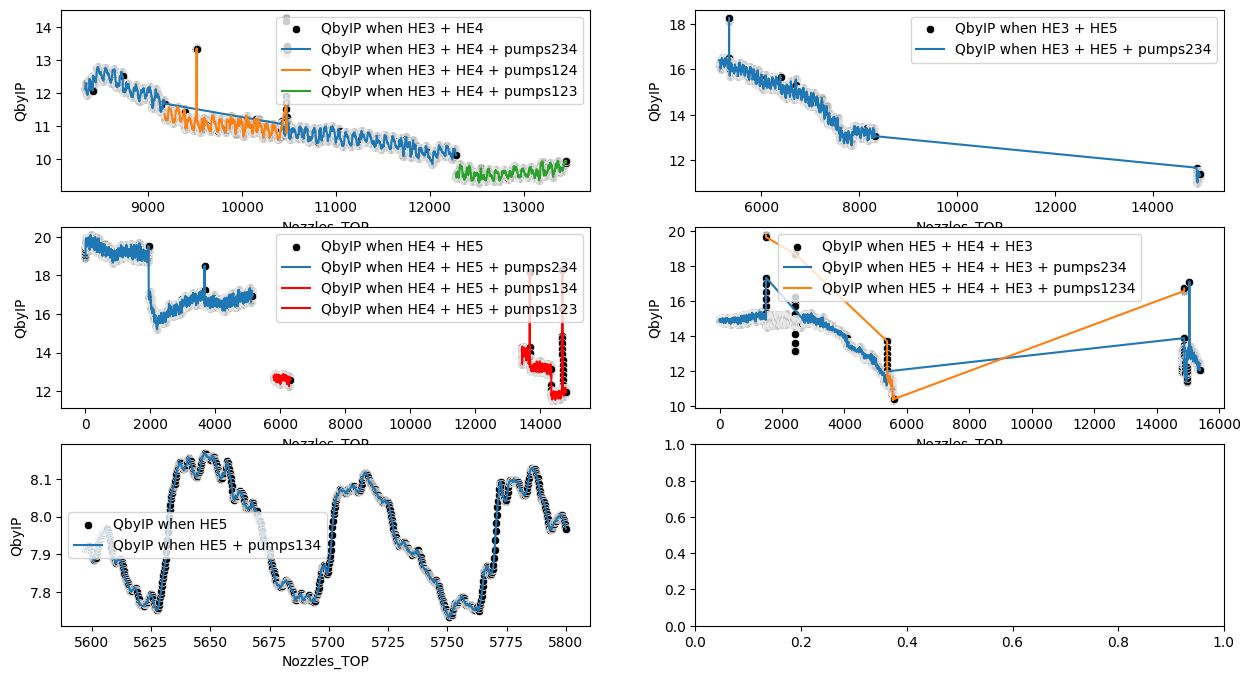

In [27]:
fig, axs = plt.subplots(3,2, figsize=(15,8))

# axs[0][0]
sns.scatterplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=df_stats["Nozzles_TOP"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5 + pumps234"
)


# axs[1][0]
sns.scatterplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps234"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps123"
)


# axs[1][1]
sns.scatterplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="QbyIP when HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"],
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5 + pumps134"
)


<AxesSubplot: ylabel='QbyIP'>

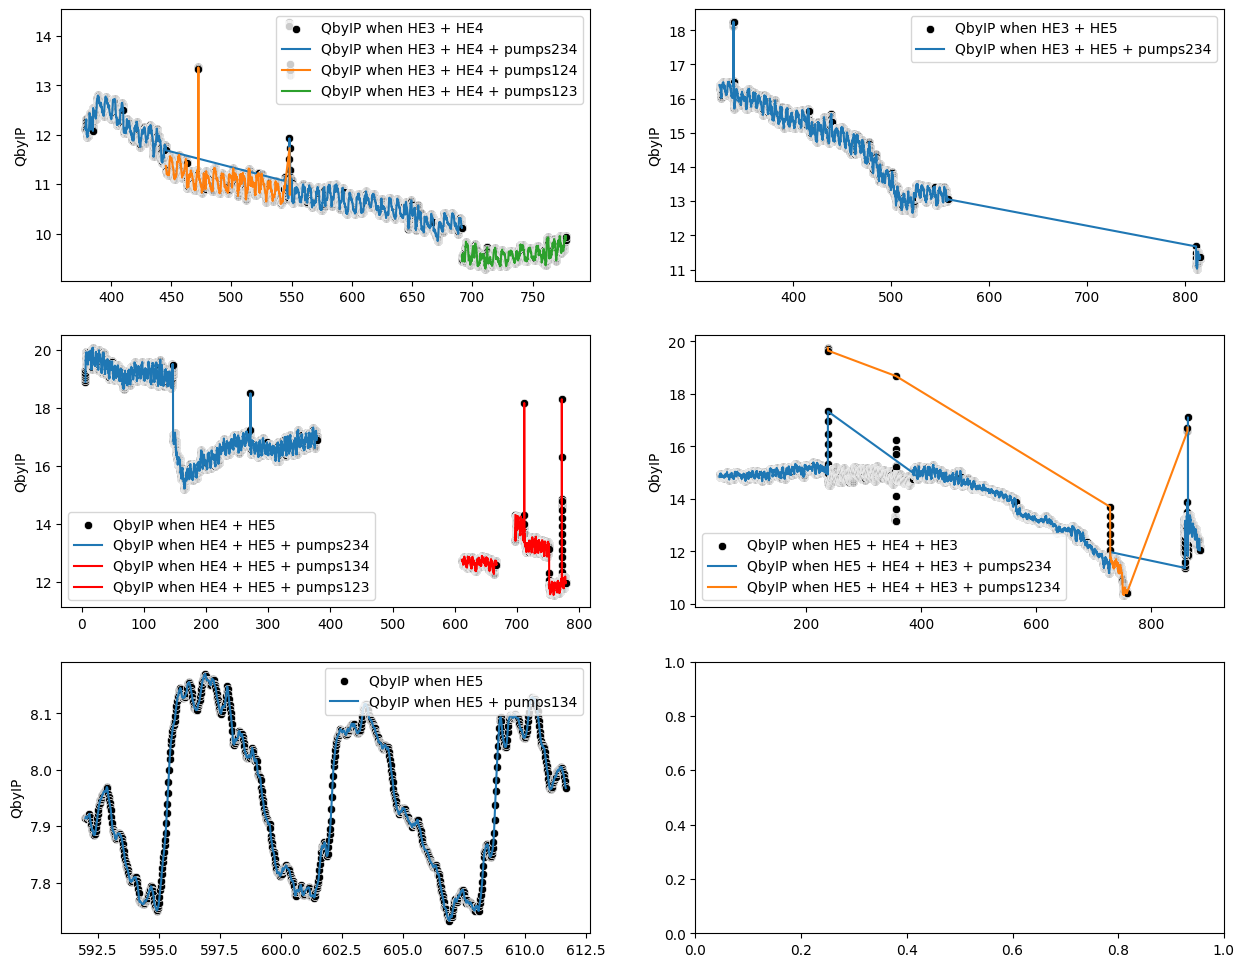

In [28]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

# axs[0][0]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5 + pumps234"
)


# axs[1][0]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps123"
)


# axs[1][1]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="QbyIP when HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5 + pumps134"
)

<AxesSubplot: ylabel='Q2'>

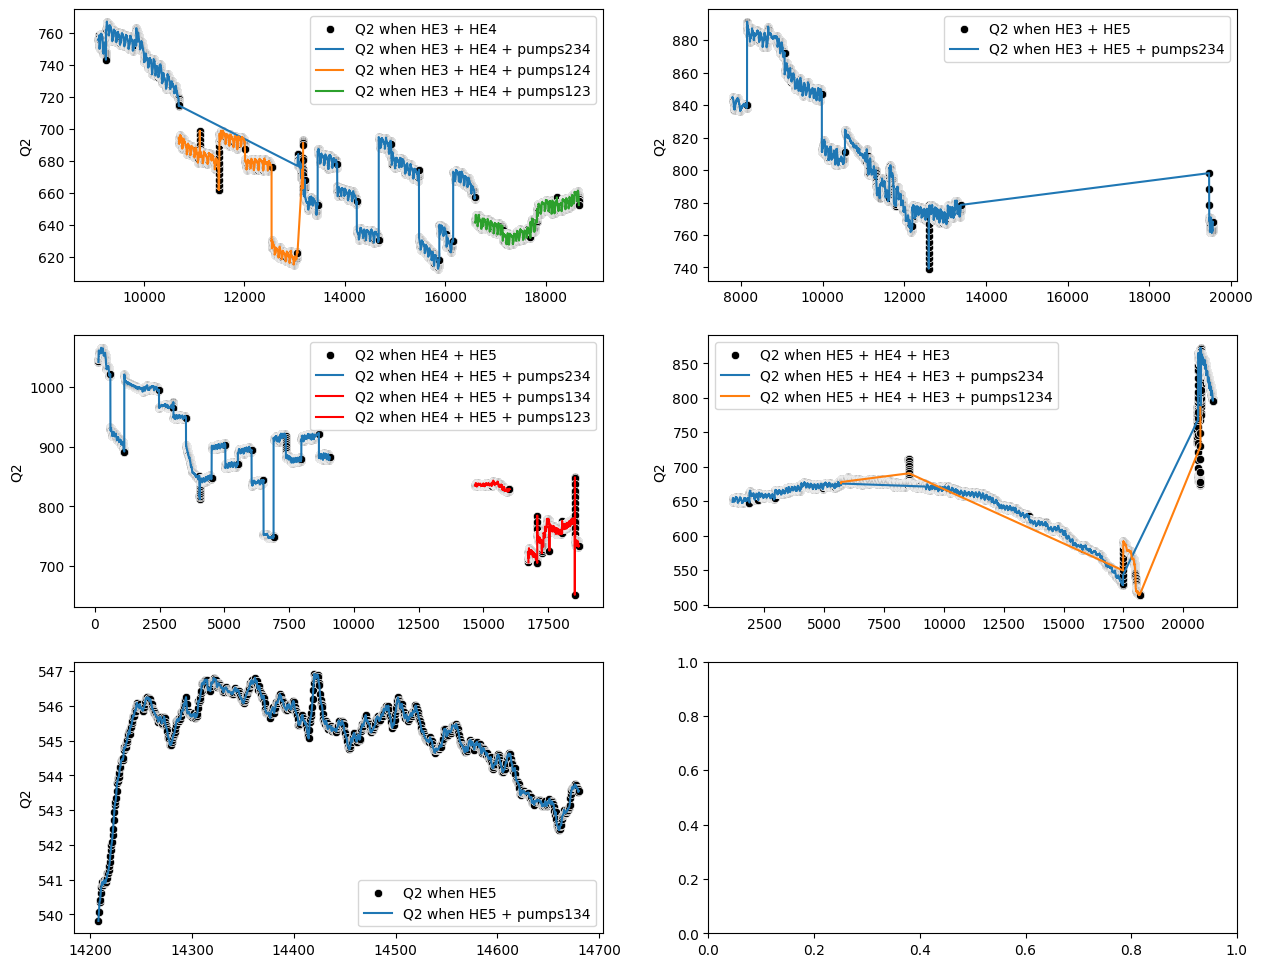

In [29]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

x = df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"]

# axs[0][0]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="Q2 when HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="Q2 when HE3 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="Q2 when HE3 + HE5 + pumps234"
)

# axs[1][0]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps123"
)



# axs[1][1]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="Q2 when HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="Q2 when HE5 + pumps134"
)

<AxesSubplot: xlabel='Nozzles_TOP', ylabel='Q2'>

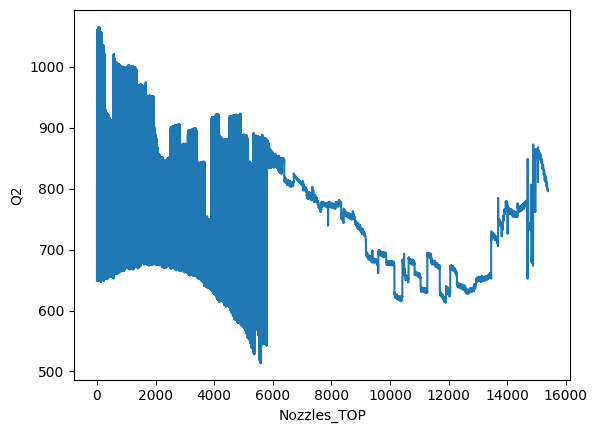

In [30]:
sns.lineplot(x=df_stats["Nozzles_TOP"], y=df_stats["Q2"])

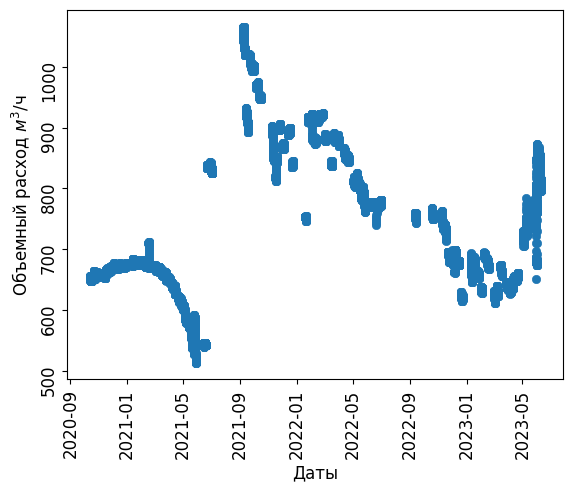

In [31]:
plt.rcParams.update({'font.size': 12})

sns.scatterplot(df_stats.loc[:,"Q2"], edgecolor = None)
plt.ylabel("Объемный расход $м^3$/ч")
plt.xlabel("Даты")
plt.tick_params(rotation=90)

Text(0.5, 0, 'Длительность работы, эфф.суток')

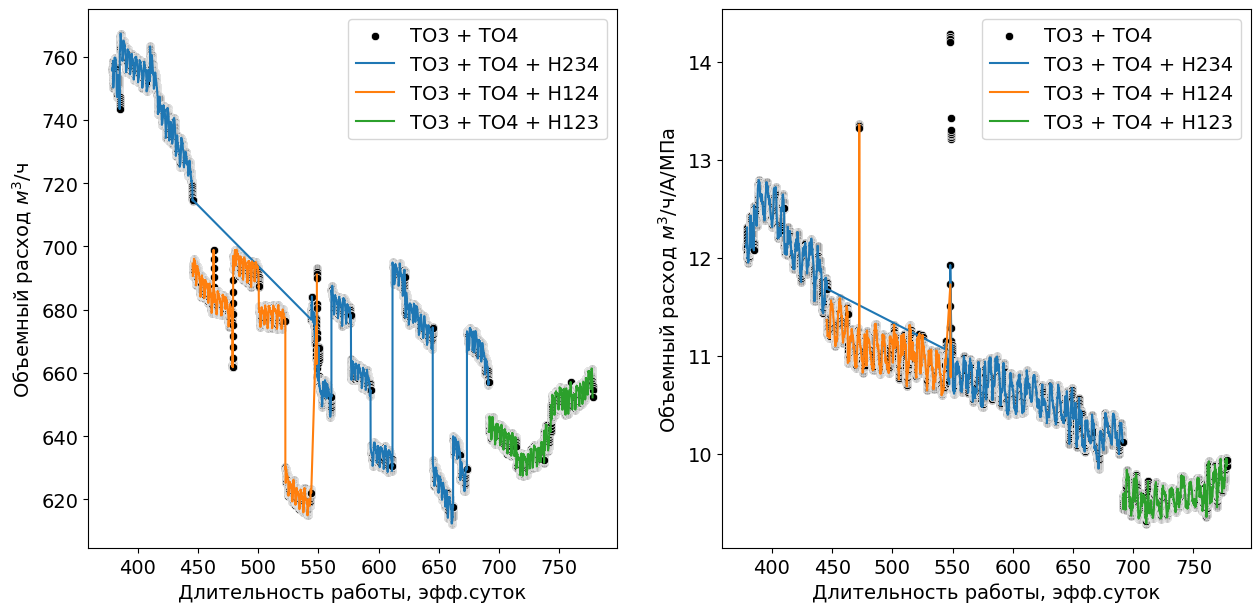

In [32]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2, figsize=(15,7))

x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н123"
)



sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[1],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н123"
)
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].set_xlabel("Длительность работы, эфф.суток")

axs[1].set_ylabel("Объемный расход $м^3$/ч/А/МПа")
axs[1].set_xlabel("Длительность работы, эфф.суток")

Text(0.5, 0, 'Длительность работы, эфф.суток')

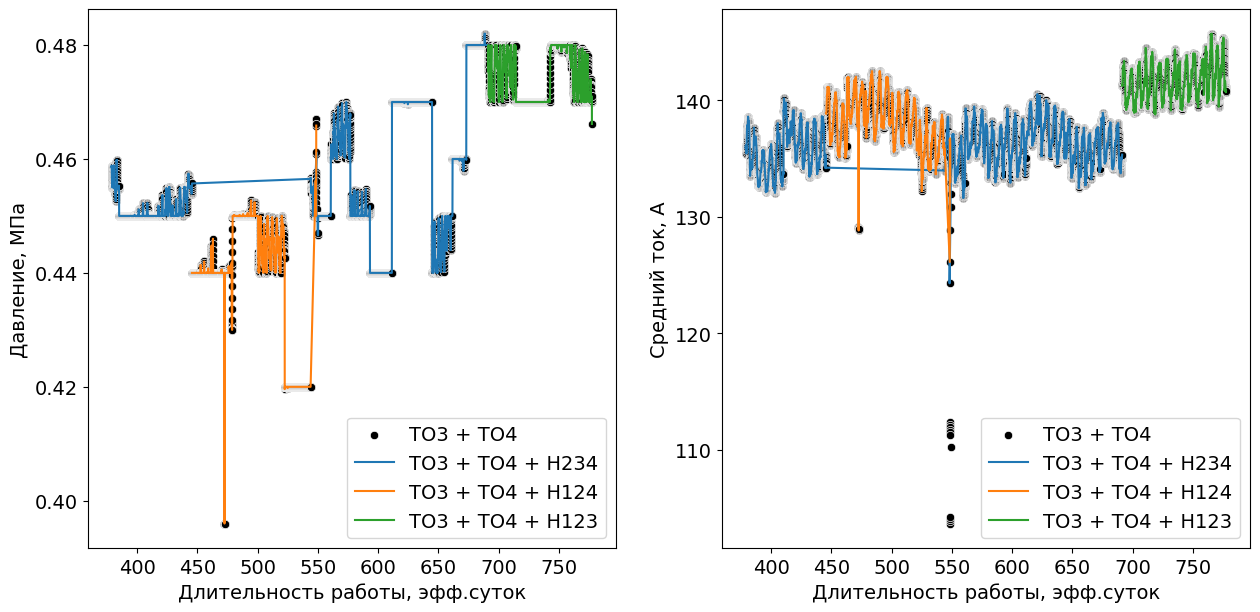

In [33]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2, figsize=(15,7))
x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

sns.scatterplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0],
    label="ТО3 + ТО4 + Н123"
)


sns.scatterplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[1],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н234"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н124"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[1],
    label="ТО3 + ТО4 + Н123"
)

axs[0].set_ylabel("Давление, МПа")
axs[0].set_xlabel("Длительность работы, эфф.суток")

axs[1].set_ylabel("Средний ток, А")
axs[1].set_xlabel("Длительность работы, эфф.суток")

# plt.tick_params(rotation=90)

(-0.14705852078975568, 0.19747549750252566)

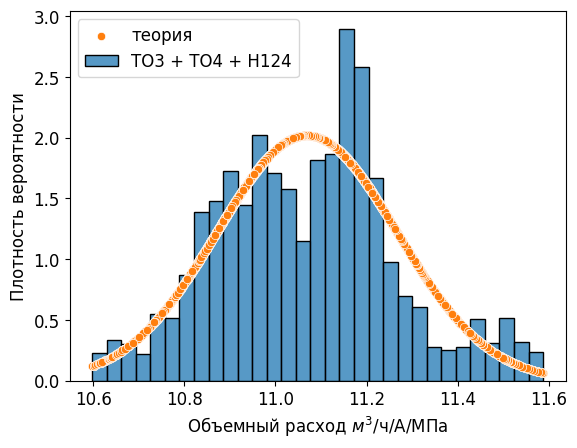

In [34]:
plt.rcParams.update({'font.size': 12})

data = df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["QbyIP"] < 11.7)
    ]

sns.histplot(
    data,
    stat="density",
    label="ТО3 + ТО4 + Н124"
)

mu, sigma = norm.fit(data)
nrm = norm(mu, sigma).pdf(data)
sns.scatterplot(x=data, y=nrm, label="теория")

plt.xlabel("Объемный расход $м^3$/ч/А/МПа")
plt.ylabel("Плотность вероятности")
scipy.stats.kurtosis(data), scipy.stats.skew(data)

(-0.839451906829928, 0.03626063034403322)

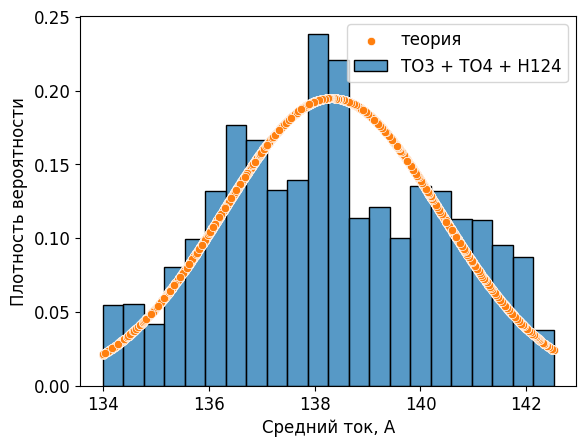

In [35]:
plt.rcParams.update({'font.size': 12})

data = df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["I2mean"] > 134)
        & (df_stats["I2mean"] < 145)
    ]

sns.histplot(
    data,
    stat="density",
    label="ТО3 + ТО4 + Н124"
)

mu, sigma = norm.fit(data)
nrm = norm(mu, sigma).pdf(data)
sns.scatterplot(x=data, y=nrm, label="теория")

plt.xlabel("Средний ток, А")
plt.ylabel("Плотность вероятности")
scipy.stats.kurtosis(data), scipy.stats.skew(data)

Text(0, 0.5, 'Вероятность')

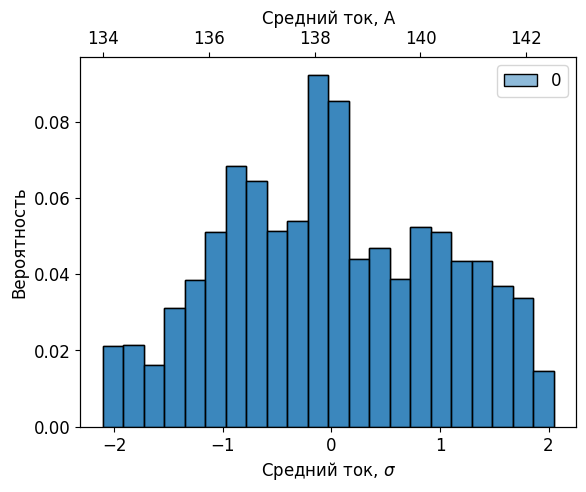

In [37]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()
ax2 = ax.twiny()
data = df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["I2mean"] > 134)
        & (df_stats["I2mean"] < 145)
    ]

data_ss = StandardScaler().fit_transform(data.to_numpy().reshape(-1,1))

sns.histplot(
    data_ss,
    stat="probability",
    ax=ax
)
sns.histplot(
    data,
    stat="probability",
    ax=ax2
)

ax2.set_xlabel("Средний ток, А")
ax.set_xlabel("Средний ток, $\sigma$")
ax.set_ylabel("Вероятность")

# After pumps status were added as important feature to describe all dependencies we may consider distribution once again

(-9.043454877157094,
 5.060280462782895e-15,
 24,
 9402,
 {'1%': -3.4310457122169113,
  '5%': -2.861847461261718,
  '10%': -2.5669336565375684},
 -10728.317041222537)

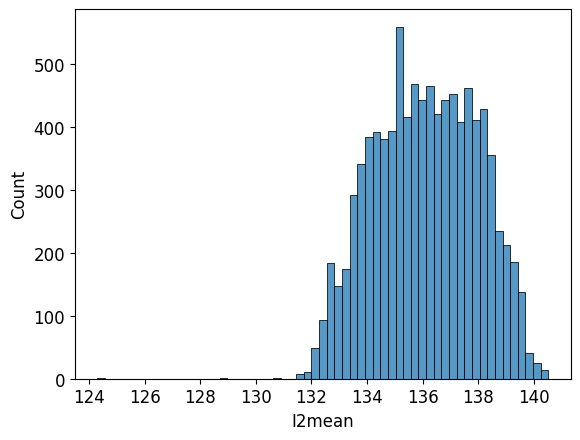

In [38]:
df_he34_p234 = (df_stats[
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ]
    ).dropna()
sns.histplot(
    df_he34_p234["I2mean"]
)

statsmodels.tsa.stattools.adfuller(
    df_he34_p234["I2mean"]
)

<AxesSubplot: >

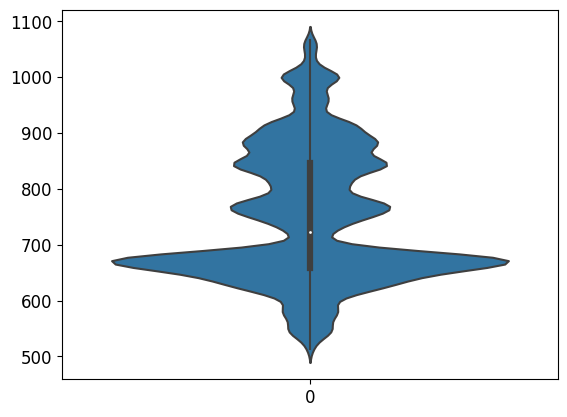

In [39]:
sns.violinplot(df_stats["Q2"])

In [40]:
df_stats["pumps2"].value_counts()

234     57963
123      9155
134      7816
124      4377
1234      981
Name: pumps2, dtype: int64

In [41]:
df_stats_oversampled_p234 = df_stats[df_stats["pumps2"] == 234].sample(frac=0.85).index

In [42]:
df_stats_undersampled = df_stats.drop(index=df_stats_oversampled_p234)

In [43]:
df_stats_Q2 = df_stats.loc[
    :, 
    [
        "Q2", "P2", "I2mean", "Nozzles_TOP", 
        "HE_TOP_mean","HE3_status",
        "HE4_status", "HE5_status",
        "pumps2",
        "HEs_num"
    ]
]

# df_stats_Q2 = df_stats_undersampled.loc[
#     :, 
#     [
#         "Q2", "P2", "I2mean", "Nozzles_TOP", 
#         "HE_TOP_mean","HE3_status",
#         "HE4_status", "HE5_status",
#         "pumps2",
#         "HEs_num"
#     ]
# ]

In [44]:
df_stats_Q2["pumps2"].value_counts()

234     57963
123      9155
134      7816
124      4377
1234      981
Name: pumps2, dtype: int64

In [45]:
numerical_cols = [
    "Nozzles_TOP","I2mean", "HE_TOP_mean"
]
ct = ColumnTransformer(
        [
            ("numerical_data", StandardScaler(), numerical_cols),
            ("categorical_data", OneHotEncoder(sparse=False), ["pumps2", "HEs_num"])
        ],
        remainder="passthrough"
).set_output(transform="pandas")

In [46]:
# df_stats_Q2 = pd.concat(
#     [
#         df_stats_Q2, 
#         pd.get_dummies(df_stats["pumps2"], prefix="pumps")
#     ], 
#     axis=1
# ) 

In [47]:
df_stats_Q2_heatmap = ct.fit_transform(df_stats_Q2)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [48]:
df_stats_Q2_heatmap.columns

Index(['numerical_data__Nozzles_TOP', 'numerical_data__I2mean',
       'numerical_data__HE_TOP_mean', 'categorical_data__pumps2_123',
       'categorical_data__pumps2_124', 'categorical_data__pumps2_134',
       'categorical_data__pumps2_234', 'categorical_data__pumps2_1234',
       'categorical_data__HEs_num_3', 'categorical_data__HEs_num_4',
       'categorical_data__HEs_num_5', 'remainder__Q2', 'remainder__P2',
       'remainder__HE3_status', 'remainder__HE4_status',
       'remainder__HE5_status'],
      dtype='object')

In [49]:
names = [
    "T работы форсунок",
    "Ток насосов",
    "T работы ТО",
    "Н123",
    "Н124",
    "Н134",
    "Н234",
    "Н1234",
    "3 ТО в работе",
    "4 ТО в работе",
    "5 ТО в работе",
    "Q",
    "P",
    "ТО3",
    "ТО4",
    "ТО5"
]

mask = [
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    True,
    True,
    True
]

<AxesSubplot: >

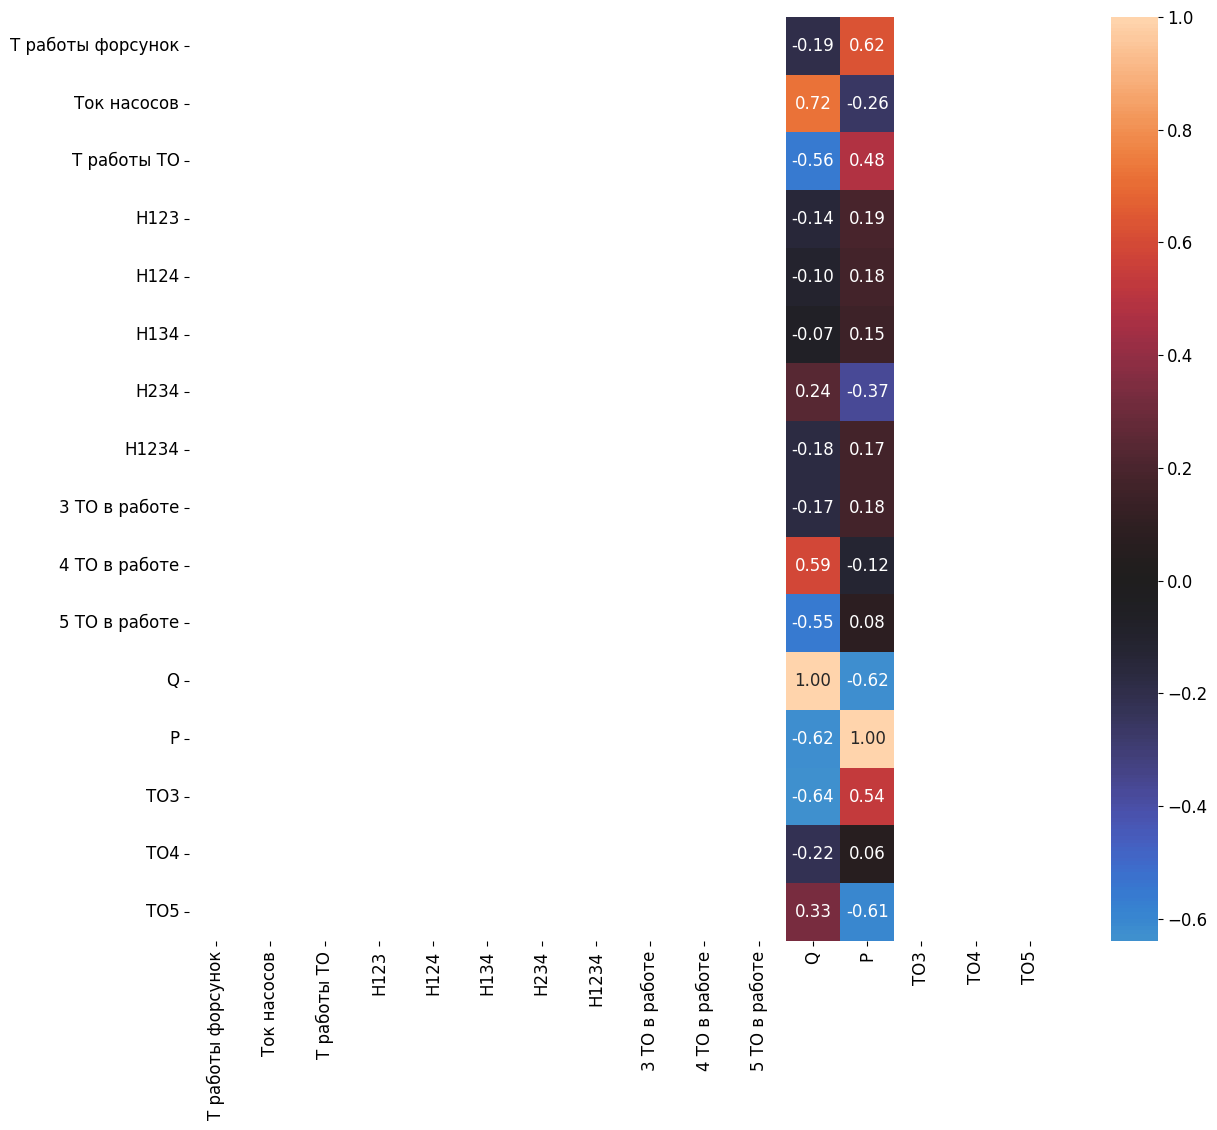

In [50]:
plt.figure(figsize=(14,12))
sns.heatmap(
    df_stats_Q2_heatmap.corr(method='spearman'), 
    annot=True, 
    fmt=".2f", 
    xticklabels=names, 
    yticklabels=names,
    center=0,
    mask=mask
)
# plt.xticks(rotation=45)

In [51]:
from sklearn.multioutput import MultiOutputRegressor

In [52]:
X = df_stats_Q2.drop(["Q2", "P2"], axis=1)
y = df_stats_Q2[["Q2", "P2"]]

In [53]:
X.shape, y.shape

((80292, 8), (80292, 2))

In [54]:
def evaluate(model, X, y, cv):
#     print(X)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [56]:
pl = make_pipeline(
    ct,
#     HistGradientBoostingRegressor()
    GradientBoostingRegressor()
).set_output(transform="pandas")


In [57]:
mor_pl = make_pipeline(
    ct,
#     HistGradientBoostingRegressor()
    MultiOutputRegressor(HistGradientBoostingRegressor())
).set_output(transform="pandas")

mor_pl_1 = make_pipeline(
    ct,
    MultiOutputRegressor(KNeighborsRegressor())
).set_output(transform="pandas")

mor_pl_2 = make_pipeline(
    ct,
    MultiOutputRegressor(tree.DecisionTreeRegressor())
).set_output(transform="pandas")

In [58]:
# multioutput
mor_gbr = mor_pl.fit(X_train, y_train)
mor_pl_1.fit(X_train, y_train)
mor_pl_2.fit(X_train, y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_data',
                                                  StandardScaler(),
                                                  ['Nozzles_TOP', 'I2mean',
                                                   'HE_TOP_mean']),
                                                 ('categorical_data',
                                                  OneHotEncoder(sparse=False),
                                                  ['pumps2', 'HEs_num'])])),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor()))])

0.9306824799376248
0.0004481966491359828


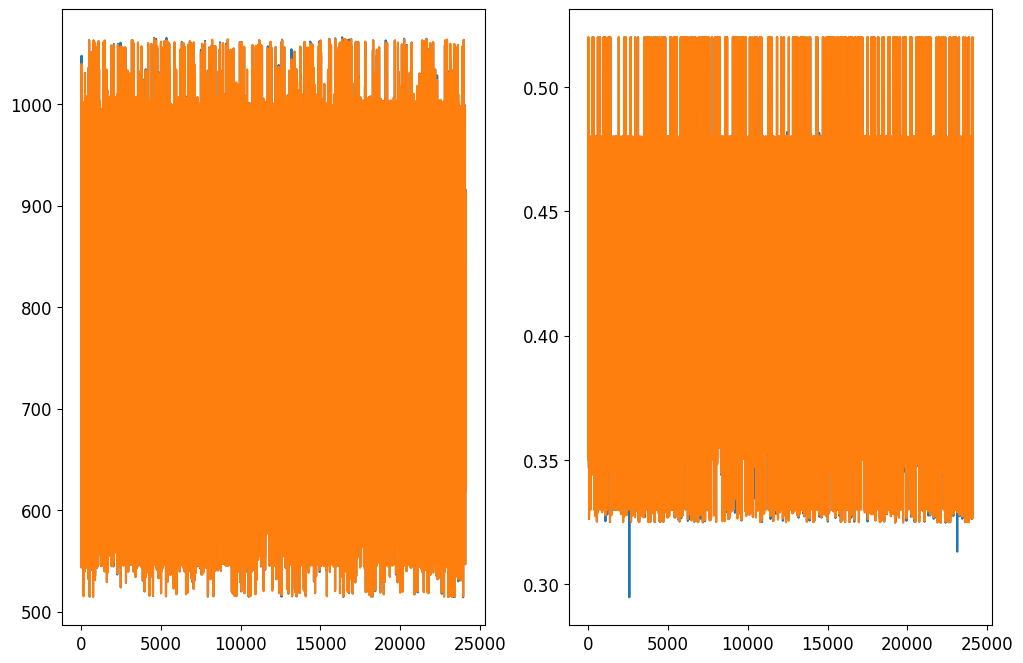

In [59]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0]
)
sns.lineplot(
    mor_pl_1.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0]
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_pl_1.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_pl_1.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_pl_1.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

0.20769963786311693
0.0001208979085225474


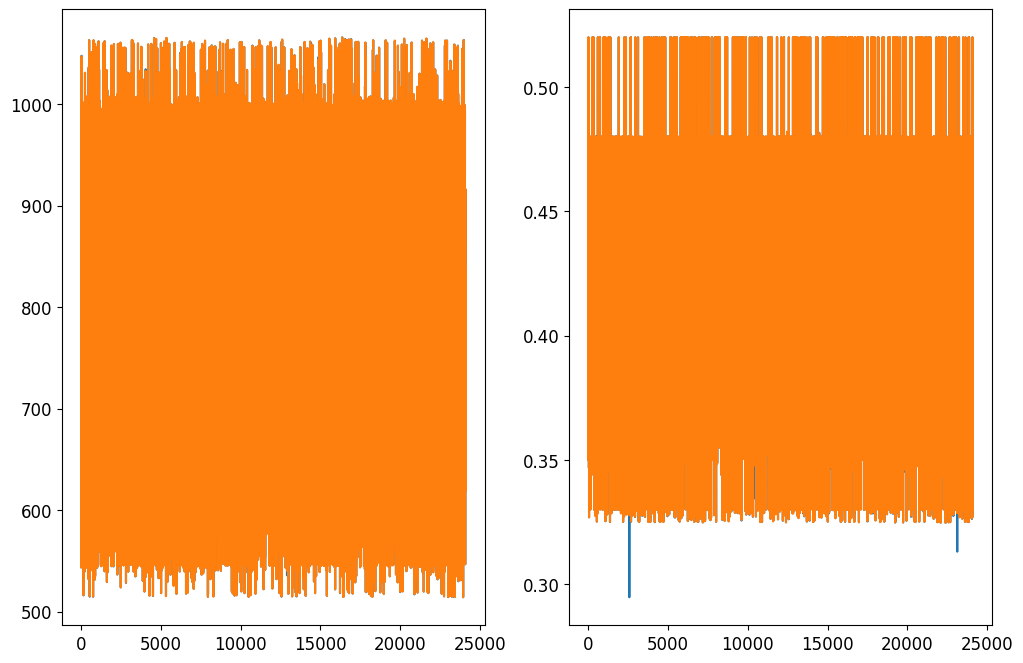

In [60]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0]
)
sns.lineplot(
    mor_pl_2.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0]
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_pl_2.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_pl_2.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_pl_2.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

2.663876359685903
0.001439405960163894


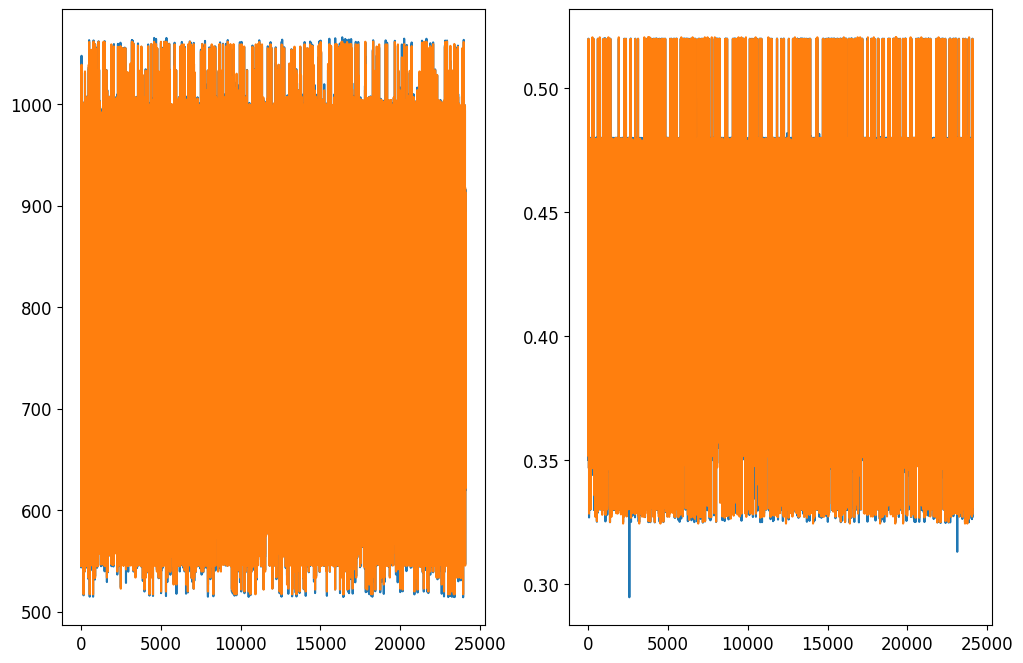

In [105]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0],
)
sns.lineplot(
    mor_gbr.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0],
    errorbar=("pi", 100)
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_gbr.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_gbr.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_gbr.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

## USE of folds to predict

In [62]:
ss_folds = list(ShuffleSplit(n_splits=4).split(X,y))
k_folds = list(KFold(n_splits=4).split(X,y))

In [63]:
gbr_pl1 = pl

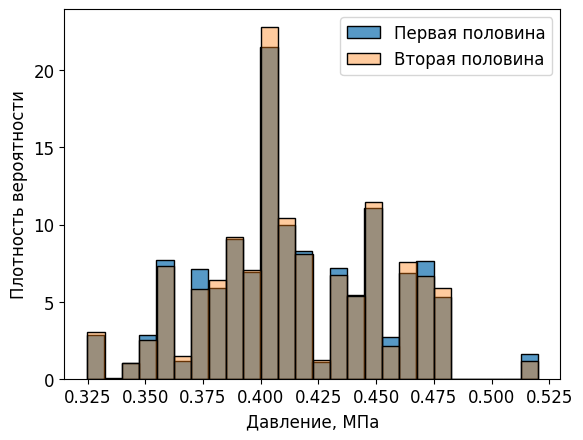

In [64]:
sns.histplot(
    y.iloc[
        ss_folds[0][1][:int(len(ss_folds[0][1])/2)]
    ]["P2"],
    stat="density",
    label="Первая половина"
    
)

sns.histplot(
    y.iloc[
        ss_folds[0][1][int(len(ss_folds[0][1])/2): ]
    ]["P2"],
    stat="density",
    alpha=0.4,
    label="Вторая половина"
)
plt.xlabel("Давление, МПа")
plt.ylabel("Плотность вероятности")
plt.legend()

<AxesSubplot: xlabel='Q2', ylabel='Count'>

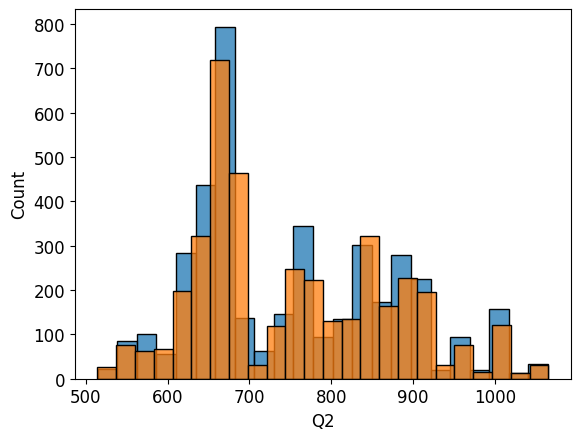

In [65]:
sns.histplot(
    y.iloc[
        ss_folds[0][1][:int(len(ss_folds[0][1])/2)]
    ]["Q2"]
)

sns.histplot(
    y.iloc[
        ss_folds[0][1][int(len(ss_folds[0][1])/2): ]
    ]["Q2"]
)

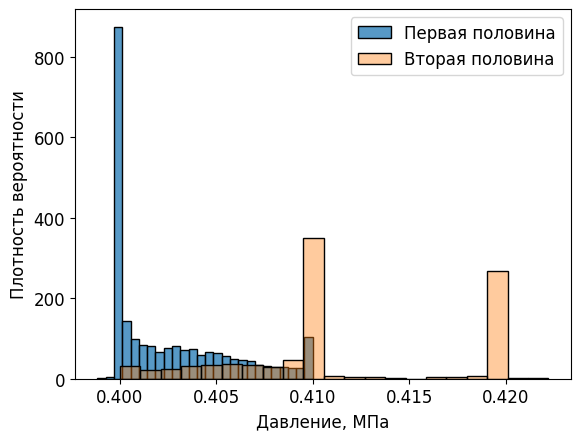

In [66]:
sns.histplot(
    y.iloc[
        k_folds[0][1][:int(len(k_folds[0][1])/2)]
    ]["P2"],
    stat="density",
    label="Первая половина"
    
)

sns.histplot(
    y.iloc[
        k_folds[0][1][int(len(k_folds[0][1])/2): ]
    ]["P2"],
    stat="density",
    alpha=0.4,
    label="Вторая половина"
)
plt.xlabel("Давление, МПа")
plt.ylabel("Плотность вероятности")
plt.legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.8049058005734759
14.955633606756301
single_pred 620.379 635.3346336067564 605.4233663932437 619.225
753.1981436860711 750.5625757984575 755.8337115736848


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.8138578540291295
17.2182432109399
single_pred 758.063 775.2812432109399 740.84475678906 758.2049999999999
749.0242900371582 746.4010022592879 751.6475778150284


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.7753663794562999
12.140250753573904
single_pred 652.769 664.9092507535739 640.6287492464261 652.975
750.7735496963196 748.1705186901803 753.3765807024589


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.8551769736892021
19.510690642059785
single_pred 949.074 968.5846906420597 929.5633093579402 950.335
750.8547276357945 748.246743203149 753.4627120684399


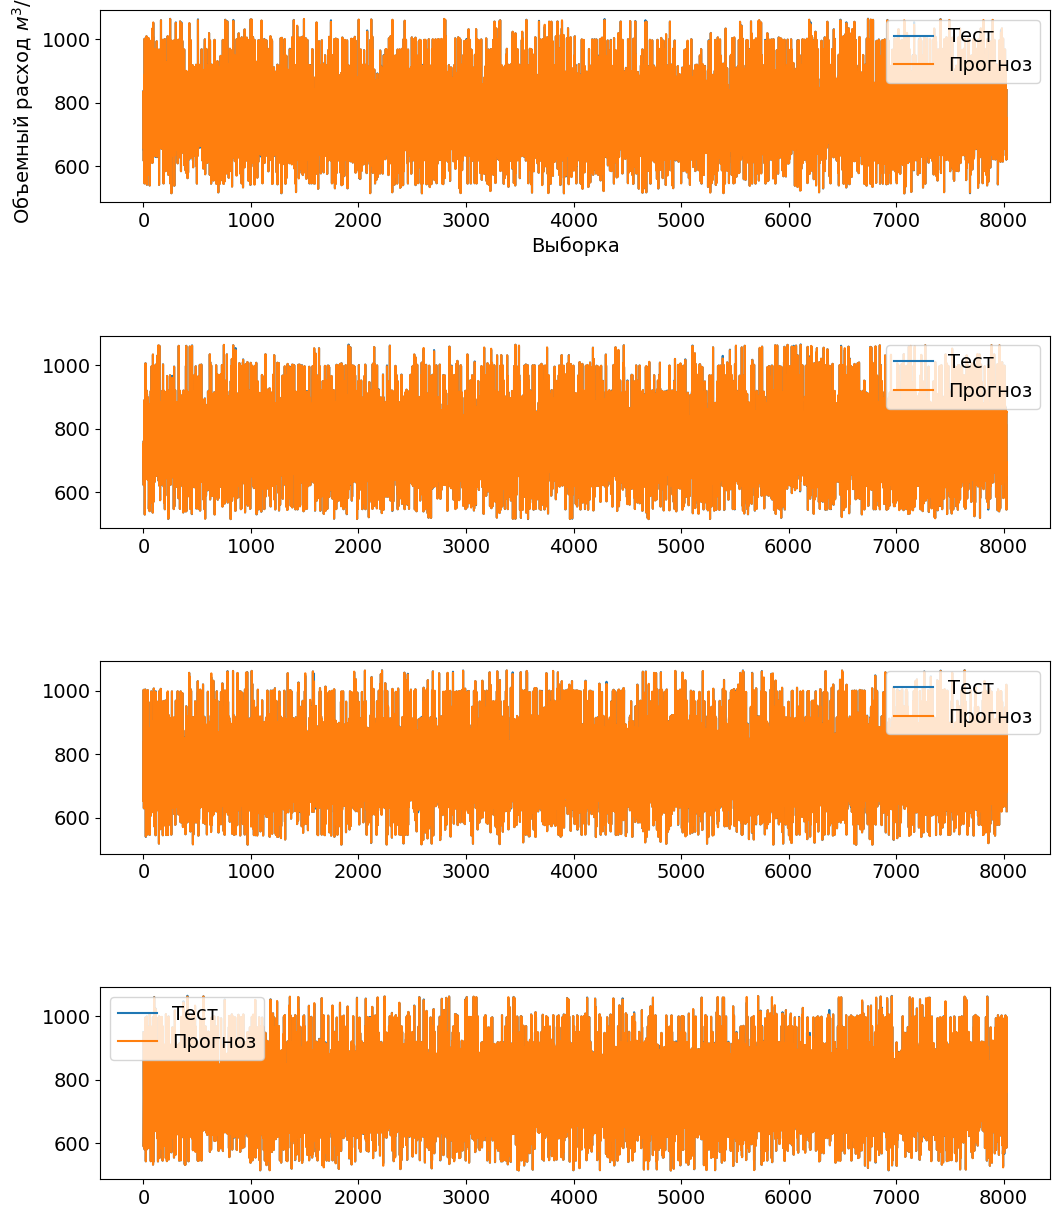

In [247]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,14))
fig.tight_layout(pad=5.0)

level = 1.96
# pred_intr_upper

for n, (tr, te) in enumerate(ss_folds):
    mor_pl_1.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n],
        label="Тест"
    )
    
    pred = mor_pl_1.predict(
         X.iloc[te])[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n],
        label="Прогноз",
        errorbar="ci"
    )
    
    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    print(interval)
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper, y.iloc[te].iloc[0]["Q2"]
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.16534993877387666
single_pred 619.28 620.2029549941963 618.3570450058037
753.2199601363731 750.5845034645953 755.8554168081508


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.22461309531459334
single_pred 758.1099999999999 771.1931161879805 745.0268838120193
748.9828119688643 746.3599738129858 751.6056501247429


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.17548251545178423
single_pred 653.12 656.4838270279662 649.7561729720338
750.7464278069223 748.1432356953145 753.34961991853


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.17871664536970017
single_pred 950.5049999999999 954.118453252334 946.8915467476658
750.8573458943149 748.2490163193669 753.4656754692629


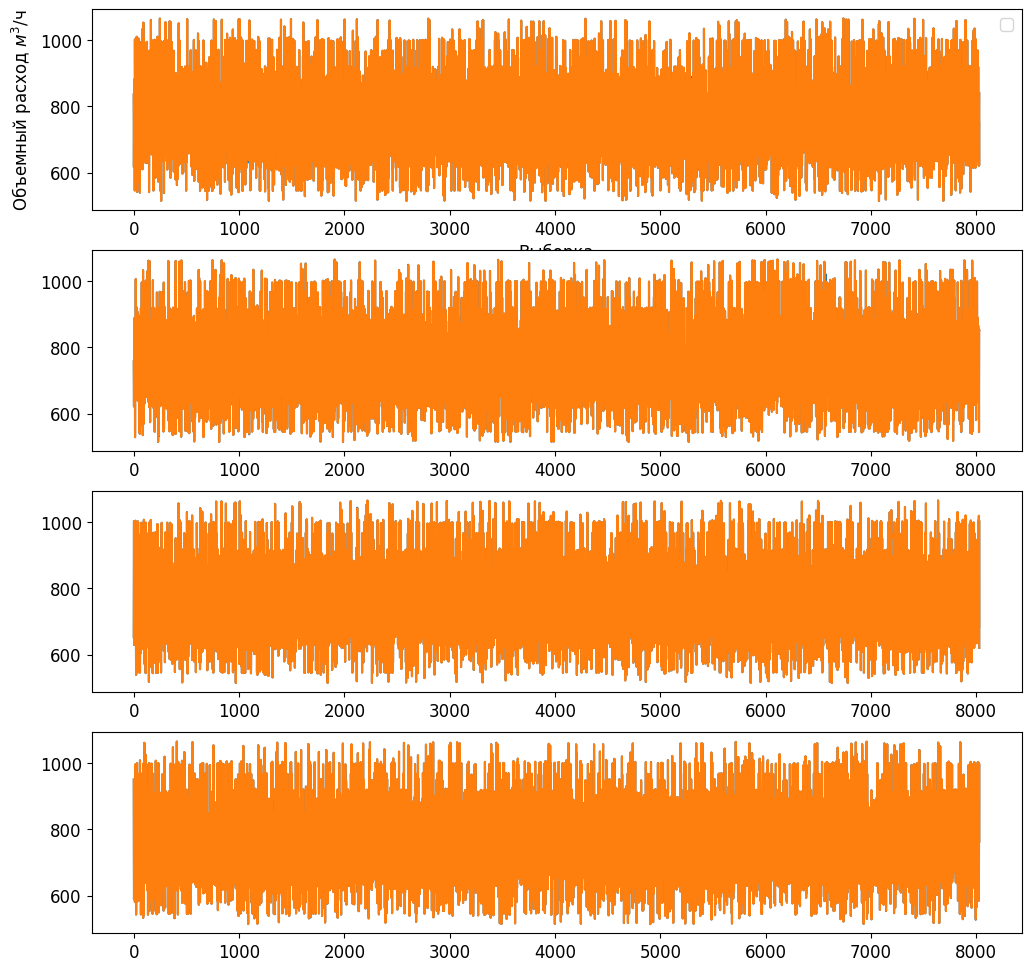

In [169]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(ss_folds):
    mor_pl_2.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    
    pred = mor_pl_2.predict(
            X.iloc[te]
        )[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n]
    )

    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.4064066877069665
single_pred 624.9018149749967 654.5822051299573 595.2214248200361
753.1844210594194 750.554213666053 755.8146284527858


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.504747582313356
single_pred 757.5499963621223 794.209809903903 720.8901828203417
748.9383010816047 746.320441402731 751.5561607604783


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.4460481171886483
single_pred 651.7111524617707 680.2489871885332 623.1733177350081
750.7973736862776 748.1991826887529 753.3955646838024


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.47742246776716
single_pred 950.8133713974254 982.4808696153059 919.1458731795449
750.8585631697391 748.255199753358 753.4619265861202


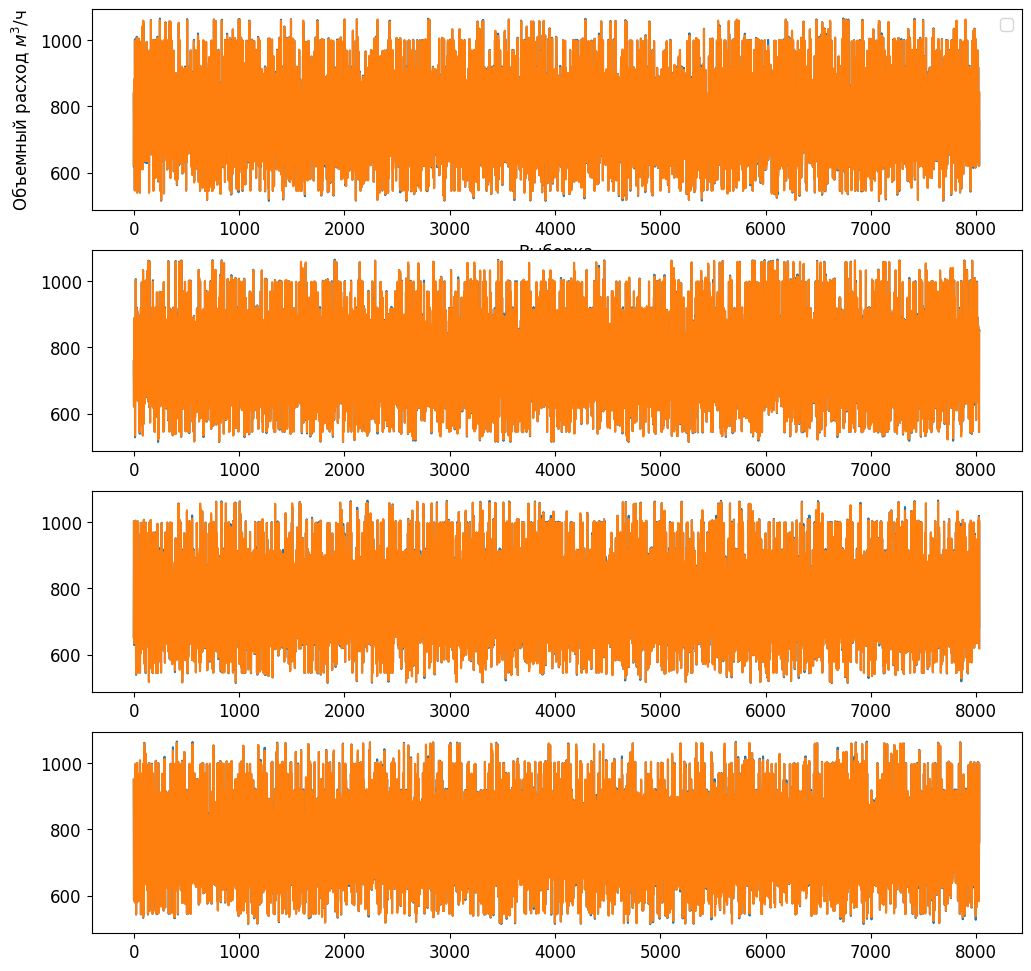

In [170]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(ss_folds):
    mor_gbr.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    
    pred = mor_gbr.predict(
            X.iloc[te]
        )[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n]
    )

    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

# Sort shuffled ind to make reverse transform to show results of prediction

In [125]:
tr0, te0 = ss_folds[0]

In [245]:
tr0.shape

(72262,)

In [126]:
te0_sorted = np.argsort(te0)

In [127]:
mor_pl_2.fit(
    X.iloc[tr0],
    y.iloc[tr0]
)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_data',
                                                  StandardScaler(),
                                                  ['Nozzles_TOP', 'I2mean',
                                                   'HE_TOP_mean']),
                                                 ('categorical_data',
                                                  OneHotEncoder(sparse=False),
                                                  ['pumps2', 'HEs_num'])])),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor()))])

In [130]:
mor_pl_2_toreverse = mor_pl_2.predict(X.iloc[te0])

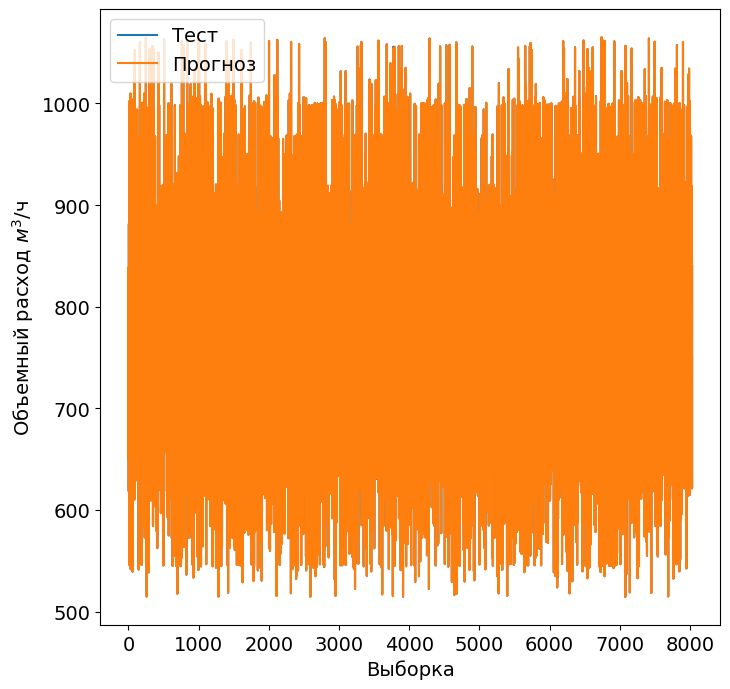

In [222]:
fig, ax = plt.subplots(figsize=(8,8))

sns.lineplot(y.iloc[te0]["Q2"].to_numpy(), label="Тест")
sns.lineplot(mor_pl_2_toreverse[:, 0], label="Прогноз")

plt.xlabel("Выборка")
plt.ylabel("Объемный расход $м^3$/ч")

plt.legend()

In [183]:
interval_toreverse = 1/( len(y.iloc[te0]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te0]["Q2"].to_numpy() - mor_pl_2_toreverse[:, 0] ) ** 2
        ) * level


()

In [184]:
lower_toreverse = mor_pl_2_toreverse[:, 0] - interval_toreverse
upper_toreverse = mor_pl_2_toreverse[:, 0] + interval_toreverse

In [196]:
lower_reversed = lower_toreverse[te0_sorted]
upper_reversed = upper_toreverse[te0_sorted]

In [192]:
lower_toreverse, upper_toreverse

(array([616.08481735, 835.15981735, 754.50981735, ..., 749.74481735,
        618.64981735, 836.87981735]),
 array([622.47518265, 841.55018265, 760.90018265, ..., 756.13518265,
        625.04018265, 843.27018265]))

In [194]:
mor_pl_2_Q2_reversed = mor_pl_2_toreverse[:, 0][te0_sorted]

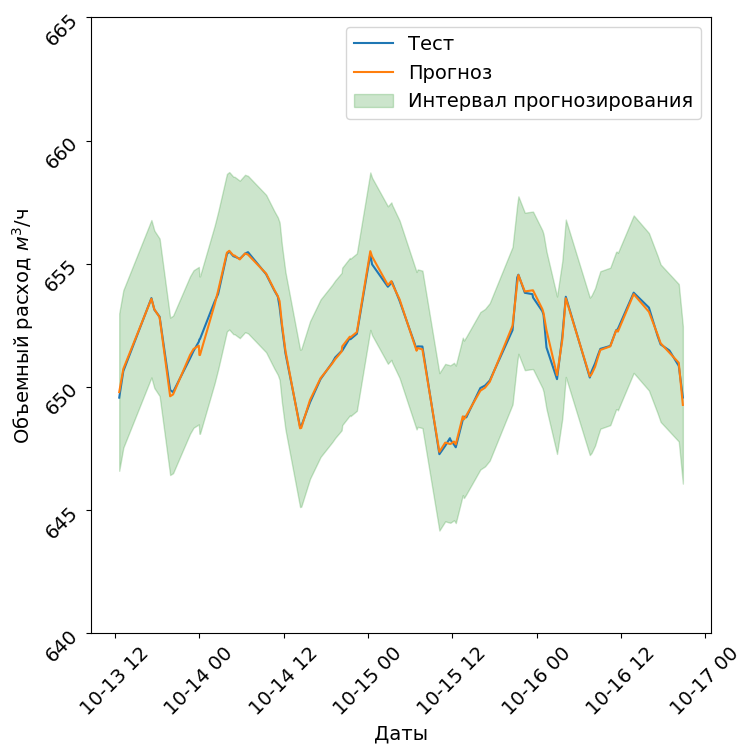

In [235]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(8,8))

start = 0
shift = 87
ind = y.index[te0[te0_sorted]][start:shift]

sns.lineplot(
    x=ind, 
    y=y.iloc[te0[te0_sorted]]["Q2"][start:shift], 
    ax=ax, 
#     color="red",
    label="Тест"
    
)

sns.lineplot(
    x=ind, 
    y=mor_pl_2_Q2_reversed[start:shift], 
    ax=ax,
    label="Прогноз"
)

ax.fill_between(
    x=ind, 
    y1=lower_reversed[start:shift],
    y2=upper_reversed[start:shift],
    alpha=0.2,
    color="green",
    label="Интервал прогнозирования"
)

ax.set_ylim(640,665)
ax.set_xlabel("Даты")
ax.set_ylabel("Объемный расход $м^3$/ч")
ax.tick_params(rotation=45)
ax.legend()

In [151]:
y.iloc[te0[te0_sorted]]

Q2      P2
Timestamp                           
2020-10-13 12:35:00  649.565  0.4000
2020-10-13 13:10:00  650.640  0.4000
2020-10-13 17:10:00  653.605  0.4000
2020-10-13 17:35:00  653.135  0.4000
2020-10-13 18:20:00  652.850  0.4000
...                      ...     ...
2023-06-09 16:00:00  798.195  0.4686
2023-06-09 16:15:00  798.090  0.4688
2023-06-09 16:30:00  798.180  0.4694
2023-06-09 17:30:00  798.725  0.4700
2023-06-09 17:45:00  798.860  0.4700

[8030 rows x 2 columns]

<AxesSubplot: xlabel='Timestamp'>

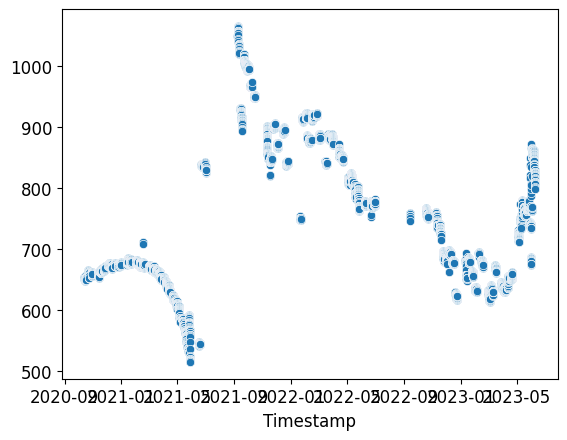

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


63.37241616410716


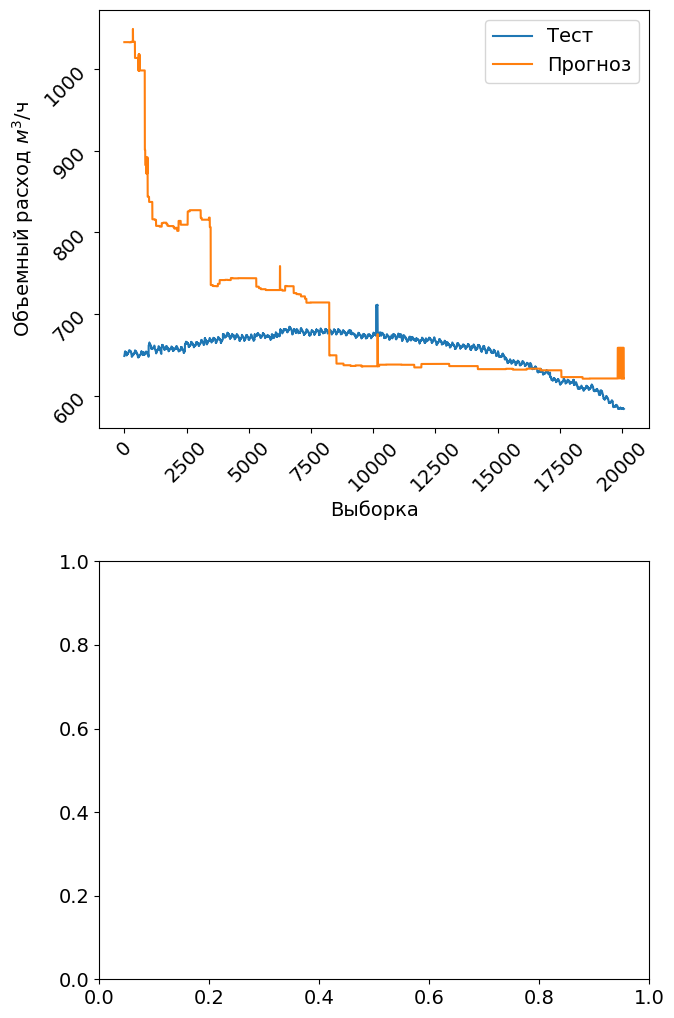

In [244]:
fig, axs = plt.subplots(len(k_folds)-2,1, figsize=(8,12))
fig.tight_layout(pad=5)

for n, (tr, te) in enumerate(k_folds[:1]):
    mor_gbr.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n],
        label="Тест"
    )
    sns.lineplot(
        mor_gbr.predict(
            X.iloc[te]
        )[:, 0],
        ax=axs[n],
        label="Прогноз"
    )
    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        mor_gbr.predict(
         X.iloc[te])[:, 0]
    ))
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].tick_params(rotation=45)
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


64.52965184374992


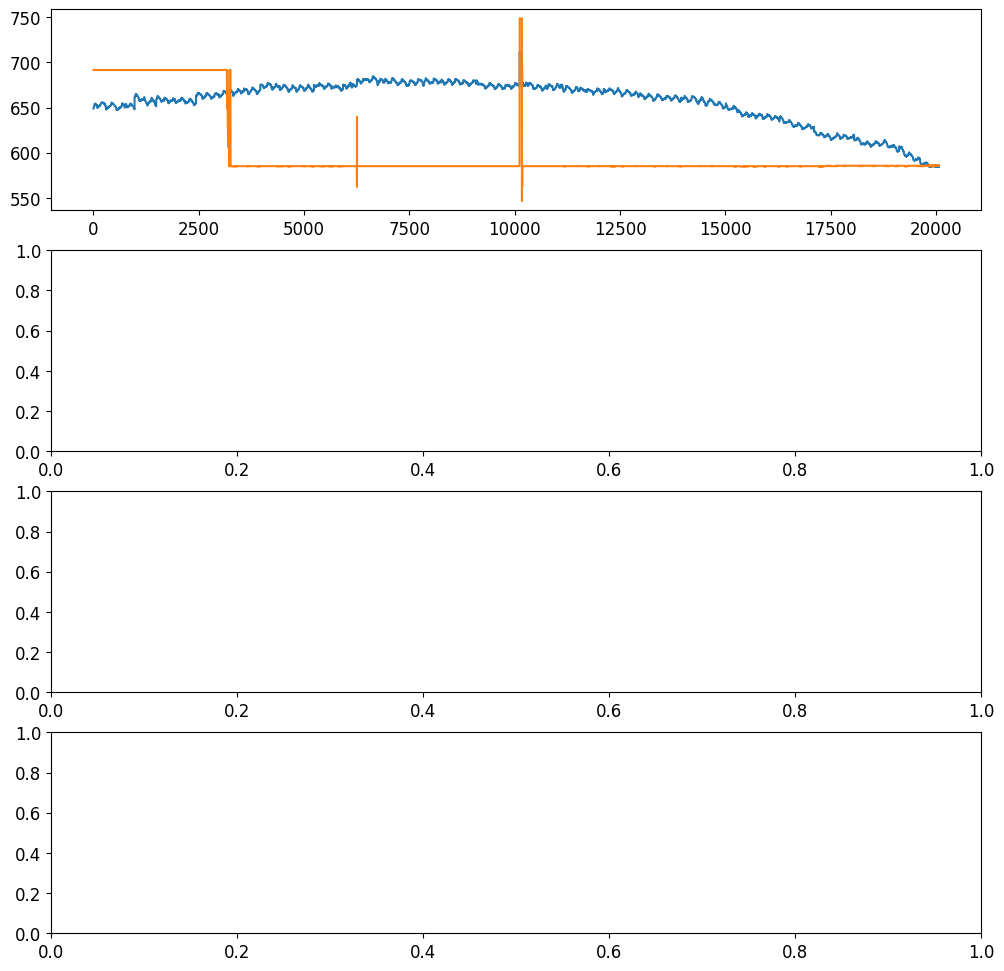

In [71]:
fig, axs = plt.subplots(len(k_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(k_folds[:1]):
    mor_pl_1.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    sns.lineplot(
        mor_pl_1.predict(
            X.iloc[te]
        )[:, 0],
        ax=axs[n]
    )
    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        mor_pl_1.predict(
         X.iloc[te])[:, 0]
    ))


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


253.15960728266086


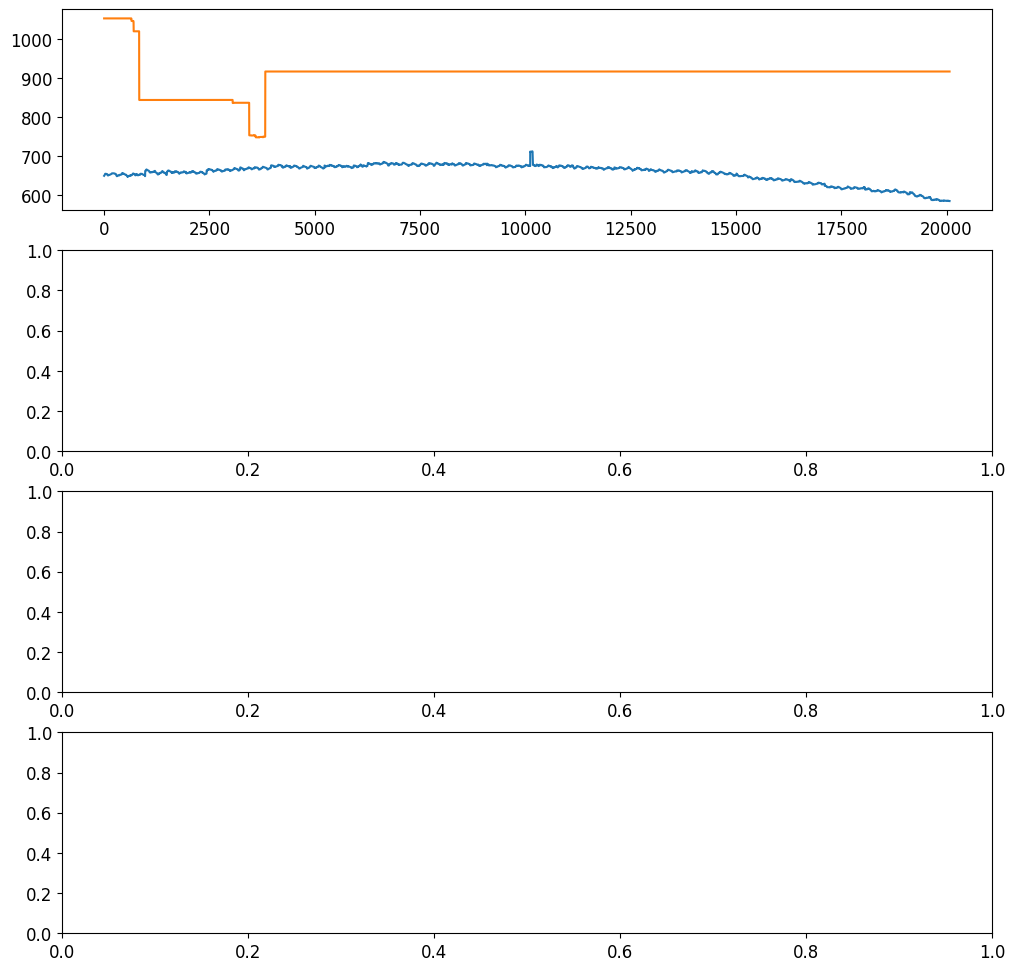

In [72]:
fig, axs = plt.subplots(len(k_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(k_folds[:1]):
    mor_pl_2.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    sns.lineplot(
        mor_pl_2.predict(
            X.iloc[te]
        )[:, 0],
        ax=axs[n]
    )
    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        mor_pl_2.predict(
         X.iloc[te])[:, 0]
    ))

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<AxesSubplot: >

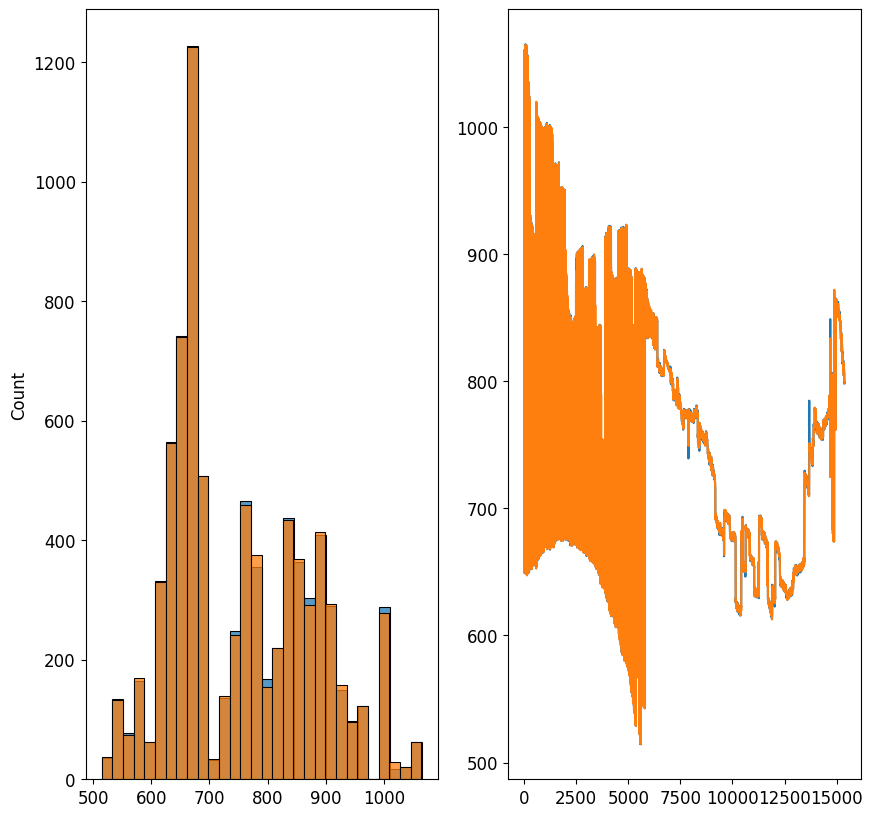

In [73]:
fig, axs = plt.subplots(1,2, figsize=(10,10))

tr, te = ss_folds[0]
# ax1 = axs.twinx()
mor_pl_1.fit(X.iloc[tr], y.iloc[tr])

sns.histplot(
    y["Q2"].to_numpy()[te],
    ax=axs[0]
)
sns.histplot(
    mor_pl_1.predict(X.iloc[te])[:, 0],
    ax=axs[0]
)

sns.lineplot(
    x=X.iloc[te]["Nozzles_TOP"].to_numpy(),
    y=y.iloc[te]["Q2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    x=X.iloc[te]["Nozzles_TOP"].to_numpy(),
    y=mor_pl_1.predict(X.iloc[te])[:, 0],
    ax=axs[1]
)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<AxesSubplot: >

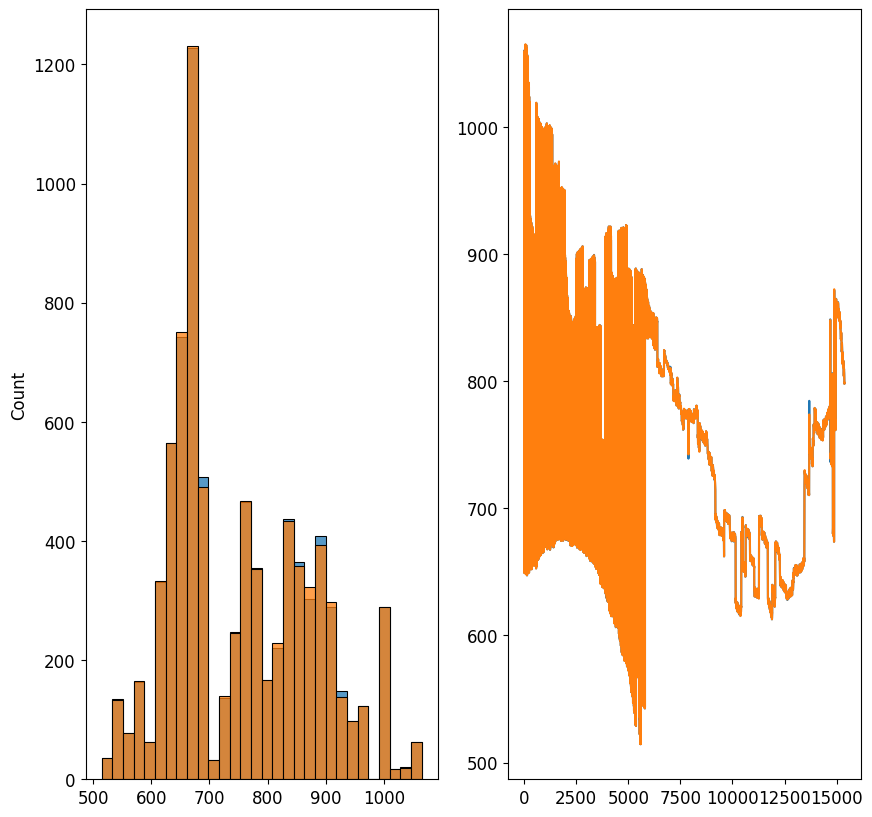

In [74]:
fig, axs = plt.subplots(1,2, figsize=(10,10))

tr, te = ss_folds[0]
# ax1 = axs.twinx()
mor_pl_2.fit(X.iloc[tr], y.iloc[tr])

sns.histplot(
    y["Q2"].to_numpy()[te],
    ax=axs[0]
)
sns.histplot(
    mor_pl_2.predict(X.iloc[te])[:, 0],
    ax=axs[0]
)

sns.lineplot(
    x=X.iloc[te]["Nozzles_TOP"].to_numpy(),
    y=y.iloc[te]["Q2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    x=X.iloc[te]["Nozzles_TOP"].to_numpy(),
    y=mor_pl_2.predict(X.iloc[te])[:, 0],
    ax=axs[1]
)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<AxesSubplot: >

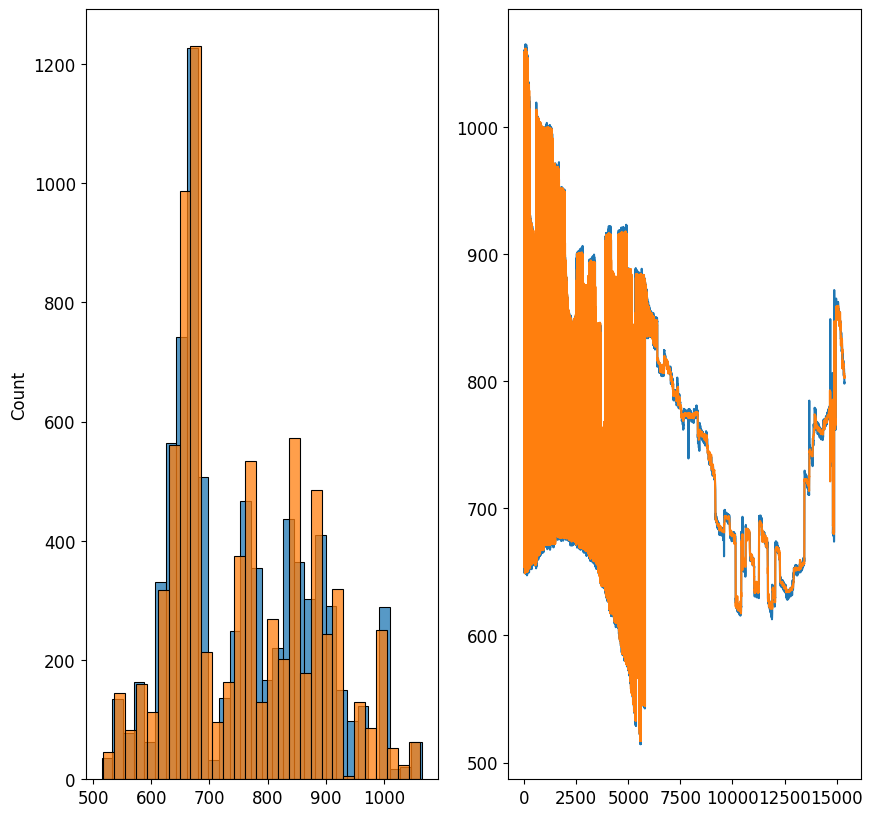

In [75]:
fig, axs = plt.subplots(1,2, figsize=(10,10))

tr, te = ss_folds[0]
# ax1 = axs.twinx()
mor_gbr.fit(X.iloc[tr], y.iloc[tr])

sns.histplot(
    y["Q2"].to_numpy()[te],
    ax=axs[0]
)
sns.histplot(
    mor_gbr.predict(X.iloc[te])[:, 0],
    ax=axs[0]
)

sns.lineplot(
    x=X.iloc[te]["Nozzles_TOP"].to_numpy(),
    y=y.iloc[te]["Q2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    x=X.iloc[te]["Nozzles_TOP"].to_numpy(),
    y=mor_gbr.predict(X.iloc[te])[:, 0],
    ax=axs[1]
)

# In case of KFold split dataset splits on sequence of folds where each split has particular order.
# So if dependent data in split has trend there is no way for model to capture this trend that is way such model has no accuracy

# Now lets check how prediction accuracy may changes with feature elimination process

In [698]:
from sklearn.feature_selection import RFECV

In [699]:
rfecv = RFECV(
    estimator=GradientBoostingRegressor(),
    step=1,
    cv=ss_folds,
    scoring="neg_mean_absolute_error",
    min_features_to_select=1
)


In [700]:
rfecv.fit(ct.fit_transform(X),y)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RFECV(cv=[(array([48850, 40508, 24469, ..., 34123,  1558, 16279]),
           array([52061, 40481, 54916, ..., 48609, 14777, 13061])),
          (array([40190, 47863, 37024, ..., 50254,  2811, 21890]),
           array([15201,  4923, 37774, ..., 51864, 49140, 10129])),
          (array([45882, 24161, 12146, ...,  4058, 47774,  7726]),
           array([14235, 19311, 19874, ...,   271, 28233, 36112])),
          (array([12811, 20316, 17870, ..., 48489, 50838, 32012]),
           array([28685, 44757, 11491, ..., 34242, 20142, 38238]))],
      estimator=GradientBoostingRegressor(), scoring='neg_mean_absolute_error')

In [701]:
rfecv.n_features_, rfecv.feature_names_in_, rfecv.ranking_

(7,
 array(['numerical_data__Nozzles_TOP', 'numerical_data__I2mean',
        'numerical_data__HE_TOP_mean', 'categorical_data__pumps2_123',
        'categorical_data__pumps2_124', 'categorical_data__pumps2_134',
        'categorical_data__pumps2_234', 'categorical_data__pumps2_1234',
        'remainder__HE3_status', 'remainder__HE4_status',
        'remainder__HE5_status'], dtype=object),
 array([1, 1, 1, 2, 4, 1, 1, 5, 1, 1, 3]))

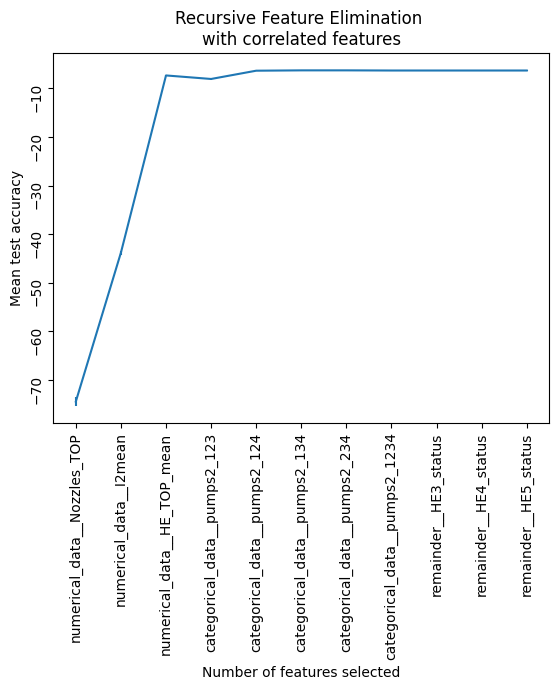

In [702]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    rfecv.feature_names_in_,
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.tick_params(rotation=90)

In [703]:
from sklearn.metrics import PredictionErrorDisplay

In [705]:
gbr_pl1_whole = pl.fit(X_train, y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [710]:
y_pred = gbr_pl1_whole.predict(X_test)

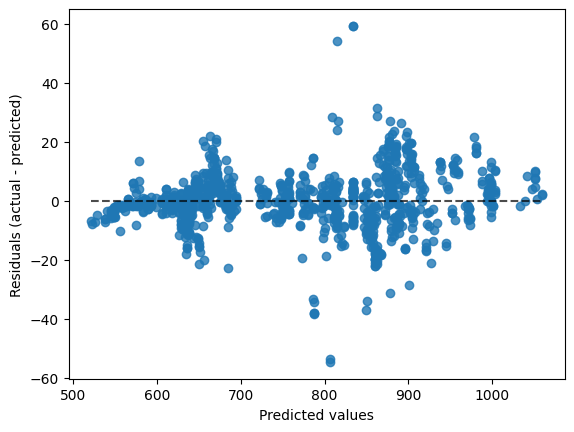

In [711]:
PredictionErrorDisplay.from_estimator(
    gbr_pl1_whole, 
    X, 
    y
)

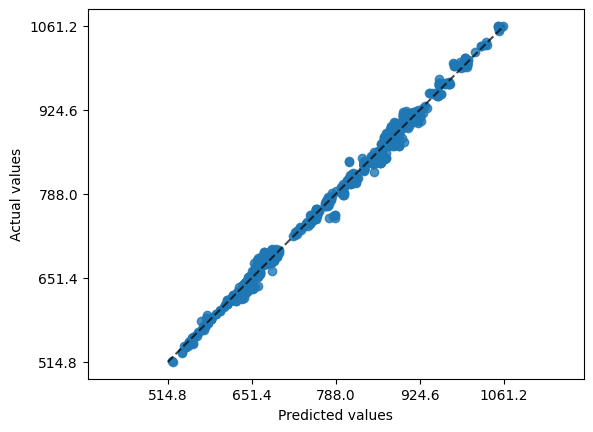

In [714]:
PredictionErrorDisplay.from_predictions(
    y_true=y_test, 
    y_pred=y_pred,
    kind="actual_vs_predicted"
)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9847525954246521, pvalue=3.3436845085747687e-38)

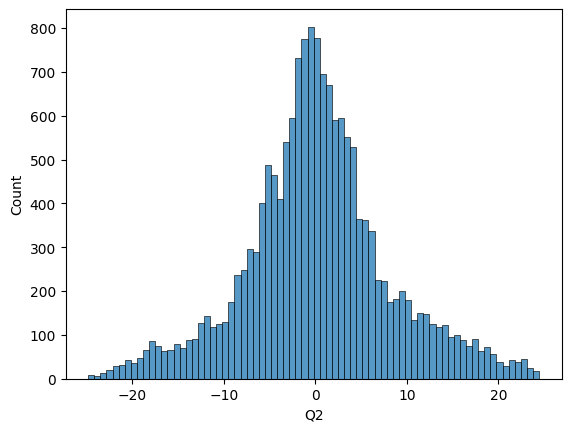

In [719]:
residuals = y_test - y_pred
sns.histplot(residuals[(residuals < 25) & (residuals > -25)])
scipy.stats.shapiro(residuals[(residuals < 25) & (residuals > -25)])

In [734]:
from numpy import var
from math import sqrt
from numpy import mean

def cohend(d1, d2):
 # calculate the size of samples
 n1, n2 = len(d1), len(d2)
 # calculate the variance of the samples
 s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
 # calculate the pooled standard deviation
 s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
 # calculate the means of the samples
 u1, u2 = mean(d1), mean(d2)
 # calculate the effect size
 return (u1 - u2) / s

In [735]:
cohend(y_test, y_pred)

0.0005186230737252157

# So now we can observe how model works on a given data


In [ ]:
inp = pd.DataFrame({
    "P2": 0.47,
    "Nozzles_TOP": 10000,
    "HE_TOP_mean":10000
    },
    index=[0]
)